In [92]:
import random
import itertools
import numpy as np
import pandas as pd
from scipy import spatial
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from math import sin, cos, sqrt, atan2, radians
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean

In [ ]:
def plots(data):
    plt.figure(figsize=(13,8))
    for i in np.unique(data):
        x,y=[],[]
        for i in np.where(data==i)[0]:
            x.append(data_test.lat.loc[i])
            y.append(data_test.long.loc[i])
        plt.plot(x, y, '-o')
        #plt.scatter(x,y)
        plt.xlabel('lat')
        plt.ylabel('long')
        #plt.title('all stations in groups')
        plt.title('all simcard movements')

In [ ]:
def labled(data):
    labled_data =[]
    for i in np.array(facts).T[0]:
        labled_data.append(rows[list(objects).index(i)])
    for i in np.array(facts).T[1]:
        labled_data.append(rows[list(objects).index(i)])
    return labled_data

In [ ]:
def speed_dist_calculator(pairs): #принимает Пару исследуемых номеров
    groupby_msisdn1 = data_test.loc[np.where(data_test.msisdn == pairs[0])[0]].groupby(['tstamp','msisdn',
                                                                                     'cid','lac','long','lat',
                                                                                     'max_dist']).size().reset_index()
    groupby_msisdn2 = data_test.loc[np.where(data_test.msisdn == pairs[1])[0]].groupby(['tstamp','msisdn',
                                                                                     'cid','lac','long','lat',
                                                                                     'max_dist']).size().reset_index()
    frames = [groupby_msisdn1,groupby_msisdn2]
    groupby_msisdn = pd.concat(frames) #получаем все нужные данные связанные с этой Парой
    #************************************************************************
    groupby_msisdn=groupby_msisdn.groupby(['tstamp','msisdn',
                                       'cid','lac','long','lat',
                                       'max_dist']).size().reset_index()
    #************************************************************************
    dist=[] # вычисляем всю дистанцию пройденную Персоной
    speed=[] # среднюю скорость когда он использовал один девайс 
    speedT2T1=[] #среднюю скорость когда он менял первый девайс на второй и обратно
    for i in range(groupby_msisdn.shape[0]-1): #для каждого события считаем пройденное расстояние с момента предыдущ.
        S = earth_dist(groupby_msisdn.lat.iloc[i],groupby_msisdn.long.iloc[i],
                            groupby_msisdn.lat.iloc[i+1],groupby_msisdn.long.iloc[i+1])
        t=(groupby_msisdn.tstamp.iloc[i+1]-groupby_msisdn.tstamp.iloc[i]).total_seconds() # а также время
        if t==0:
            speed.append(0)
        else:
            speed.append(S*1000/t)
        dist.append(S)
        if groupby_msisdn.msisdn.iloc[i]!=groupby_msisdn.msisdn.iloc[i+1]:
            if t==0:
                speed.append(0)
            else:
                speedT2T1.append(S*1000/t)
    #************************************************************************
    if np.mean(speedT2T1)==0:
        ratio=0
    else:
        ratio = np.mean(speed)/np.mean(speedT2T1) 
    #************************************************************************  
    
    trgt_pssble = 0    
    if list(pairs) in pp3:
        trgt_pssble=1.0
    else:
        trgt_pssble=0.0
    #************************************************************************
    return np.array((trgt_pssble,sum(dist),ratio,np.mean(speed),np.mean(speedT2T1))) #,{'possible_pair':trgt_pssble,
            #'dist':sum(dist),
            #'ratio': ratio,
            #'speed':np.mean(speed),
            #'speedT2T1':np.mean(speedT2T1)}

In [58]:
def time_series_plotter(data1,data2,tm_data):
    plt.figure(figsize=(15,7))
    try:
        for i,j in zip(data1,data2):
            x,y,x1,y1=[],[],[],[]
            for m in np.where(tm_data.msisdn==i)[0]:
                x.append(tm_data.tstamp.loc[m])
                y.append(tm_data.new_cid.loc[m])
            for n in np.where(tm_data.msisdn==j)[0]:
                x1.append(tm_data.tstamp.loc[n])
                y1.append(tm_data.new_cid.loc[n])    
            plt.plot(x,y)
            plt.plot(x1,y1)
            plt.xlabel('time')
            plt.ylabel('serial number of base station')
            plt.title('Time serries')
    except:
            i,j=data1,data2
            x,y,x1,y1=[],[],[],[]
            for m in np.where(tm_data.msisdn==i)[0]:
                x.append(tm_data.tstamp.loc[m])
                y.append(tm_data.new_cid.loc[m])
            for n in np.where(tm_data.msisdn==j)[0]:
                x1.append(tm_data.tstamp.loc[n])
                y1.append(tm_data.new_cid.loc[n])    
            plt.plot(x,y)
            plt.plot(x1,y1)
            plt.xlabel('time')
            plt.ylabel('serial number of base station')
            plt.title('Time serries')
    #return x,x1,y,y1 

In [ ]:
def earth_dist(lat1,lon1,lat2,lon2):
    R = 6373.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

#### Создадим датафреймы с исходными данными

In [ ]:
data_test = pd.read_csv('02_Data_test.csv', sep = ';')
event_type = pd.read_excel('04_event_type.xlsx')
known = pd.read_excel('01_Факты.xlsx')
# c файлом 03.устройства вышло немного сложнее...
with open('03_устройства.csv', encoding='utf-8', errors='ignore') as f:
    contents = f.readlines()
    devices=[]
    for i in contents:
        devices.append(i.replace('""','').replace('"','').replace('\n','').split(','))    
    devices = pd.DataFrame(devices[1:], columns=devices[0])

In [3]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174123 entries, 0 to 174122
Data columns (total 12 columns):
lac            174123 non-null int64
cid            174123 non-null int64
msisdn         174123 non-null int64
imei           162535 non-null float64
event_type     174123 non-null int64
tstamp         174123 non-null int64
long           174123 non-null float64
lat            174123 non-null float64
max_dist       174123 non-null int64
cell_type      174123 non-null object
start_angle    174123 non-null float64
end_angle      174123 non-null float64
dtypes: float64(5), int64(6), object(1)
memory usage: 15.9+ MB


In [3]:
data_test.head(2)

lac    cid        msisdn          imei  event_type         tstamp  \
0  5029  40798  158529599791  3.531111e+14           0  1369252800974   
1  7782  56870  158520145943  1.292900e+13           5  1369252801396   

      long      lat  max_dist cell_type  start_angle  end_angle  
0  37.9305  55.7815      2101   OUTDOOR        220.0      280.0  
1  37.4239  55.7426         2   OUTDOOR         45.0      105.0

#### Отобразим сколько всего уникальных групп станций, номеров, станций , девайсов и тд.

In [4]:
for i in list(data_test.columns):
    print(i,' : ',len(np.unique(data_test[f'{i}'])))

lac  :  70
cid  :  18891
msisdn  :  2361
imei  :  14128
event_type  :  10
tstamp  :  172214
long  :  3480
lat  :  3092
max_dist  :  3286
cell_type  :  3
start_angle  :  191
end_angle  :  192


### 1. Немного визуализаций...

####  С помощью функции plots, я cперва нарисовал все перемещения каждой симкарты,общая картина не особо информативна,но уже напоминает мне один определенный город

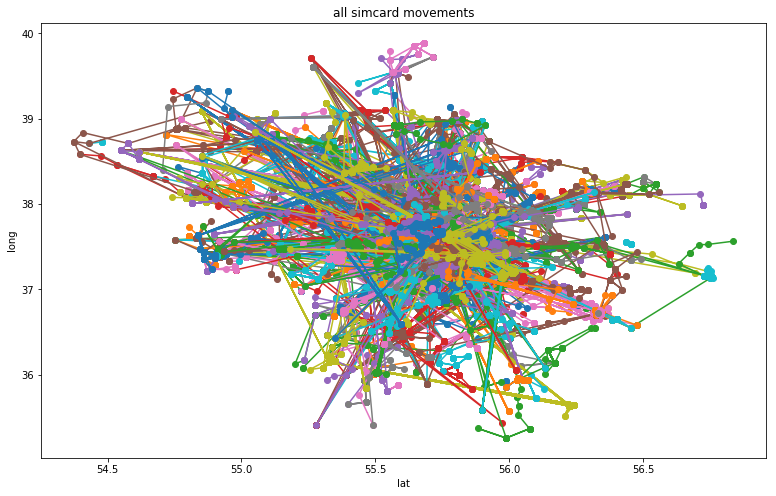

In [17]:
plots(data_test.msisdn)

#### Когда я отрисовал каждую группу станций("cid") картина еще больше стала похоже на Москву, плюс без особой  трудности можно определить что номера оператора Мегафон, а координаты на гуглмапс показывают регион Москвы+область. Так же можно заметить что точки идут четко вдоль линий метро, потому как чаще всего возле станций находятся  торговые центры и тд. Ближе к центру все естественно сгущается.

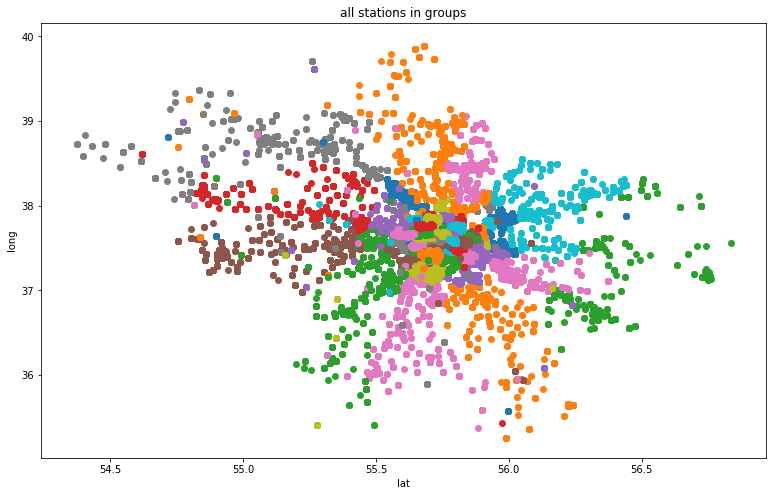

In [15]:
plots(data_test.lac)

### 2. Идея с замерами расстояний между векторами-объектами .Сделаем огромные вектора где фичи это станции

In [203]:
frame = data_test.groupby(['msisdn', 'cid']).size().reset_index(name='counts')
features = np.unique(frame.cid)
objects = np.unique(frame.msisdn)

#### Отсортируем данные по номерам и посчитаем сколько раз номер был в зоне каждой баз.станции. Создадим матрицу в которой по строкам будут распологаться номера-объекты, а в качестве признаков будут станции, в ячейках - число, сколько раз данный номер был в зоне этой станции. Получили векторы длинной равной количеству станций

In [15]:
rows=[]
for i in objects:
    vector = np.zeros(len(np.unique(frame.cid))) 
    for m in np.where(frame.msisdn==i)[0]: 
        vector[list(features).index(frame.cid.loc[m])]=frame.counts.loc[m]
    rows.append(vector)

In [96]:
df.shape

(2361, 18891)

####  Загружаем все тренировочные данные, пары наших номеров, которые точно принадлежат одной Персоне

In [4]:
facts1 = list(known.values)
facts2=[]
facts2.append([158530067653,158528861653]) # + пара из Header
for i in facts1:
    facts2.append(list(i)) 
facts = facts2

#### Теперь удалим номера которых нет в общем датасете 

In [5]:
count = 0
for i in facts:
    idx=0
    for j in i:
        if j not in msisdn:
            print(count, idx, j)
        idx+=1
    count += 1
facts.remove(facts[1])
facts.remove(facts[17-1])

1 1 158528852857
17 1 158530004641


####  Создаем отдельный массив векторов из наших размеченных номеров

In [62]:
labled_data = labled(rows)

###  Понизим размерность  методом главных компонент 
#### Создадим вектор для замера точности наших предиктов, создадим размеченные данные с новой размерностью и попробуем на них NearestNeighbors, экспериментальным путем определено что n_components=1500 дает лучшую точность,но этого все равно посредственный результат.

In [138]:
fct = np.linspace(119,238,120) #для замера точности наших предиктов
pca = PCA(n_components=1500)
pca.fit(rows)
new = pca.transform(rows)
# Создадим размеченные данные с новой размерностью
labled_data = labled(new)
# Попробуем 1NN  
nbrs = NearestNeighbors(n_neighbors=2, n_jobs=-1)
nbrs.fit(labled_data)
distances, indices = nbrs.kneighbors(labled_data)
pred = indices.T[1][0:120]
print(1500,accuracy_score(fct,pred))

1500 0.4166666666666667


####  attempt with simple distance measuring (same result)

In [182]:
prd=[]
for i in range(0,120):
    dist=[]
    for j in range(0,238):
        if i!=j:
            dist.append([j,euclidean(labled_data[i],labled_data[j])])
        else:
            dist.append([j,10000])
    prd.append(list(np.array(dist).T[1]).index(min(((np.array(dist)).T)[1])))

In [184]:
accuracy_score(prd,fct)

0.4166666666666667

### 3. Идея с использованием временных рядов. Попробовать для каждого номера построить временной ряд , и потом сравнить similarity при помощи https://en.wikipedia.org/wiki/Dynamic_time_warping

#### Пронумеруем наши станции, чтобы вместо шкалы от 0 до 65000, иметь шкалу от 0 до 18000

In [577]:
labelencoder = LabelEncoder()
tm_data['new_cid'] = labelencoder.fit_transform(tm_data.cid)

####  Отобразив для каждой пары номеров принадлежащих одной Персоне -их временные ряды для номеров, я увидел что графики очень сильно расходятся и пришел к выводу что метод с DTW вряд ли сработает...

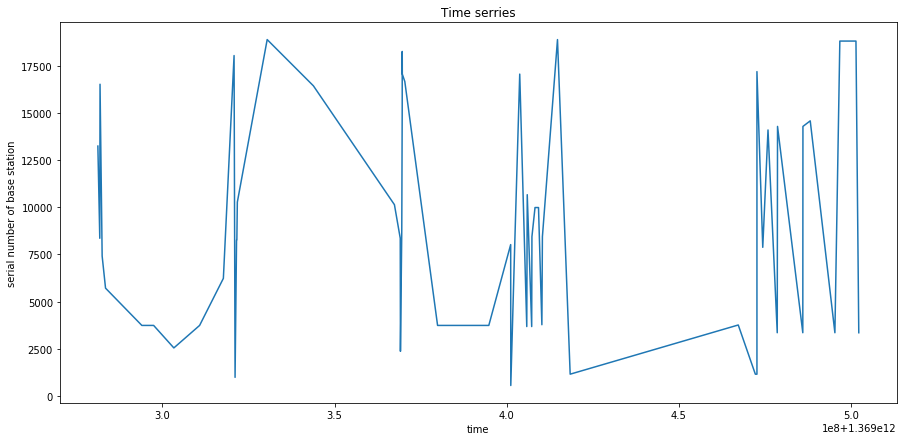

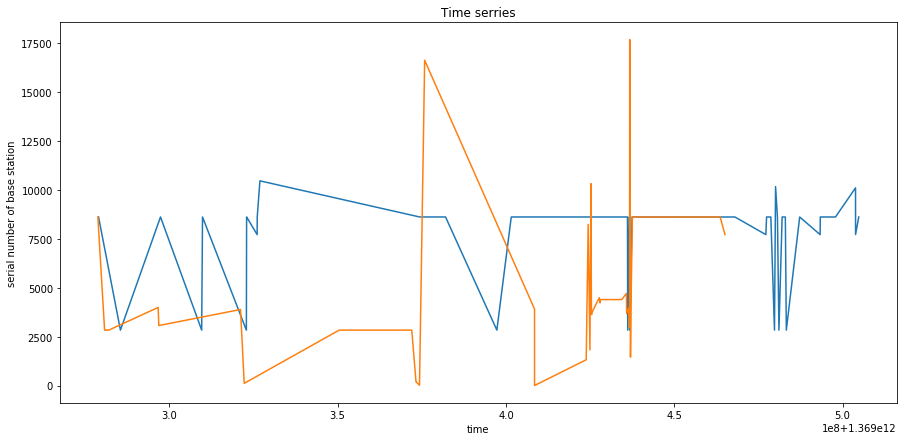

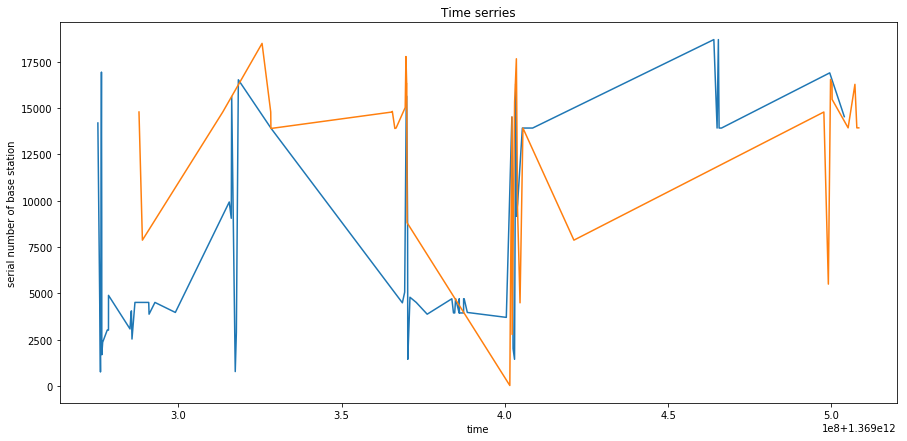

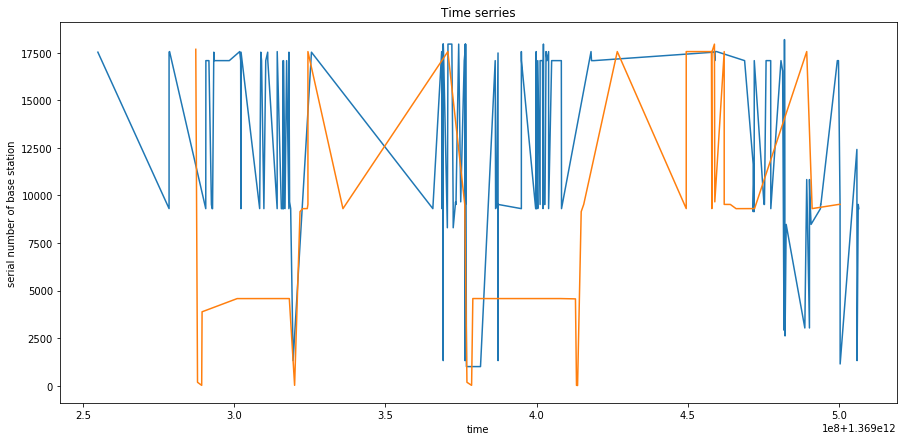

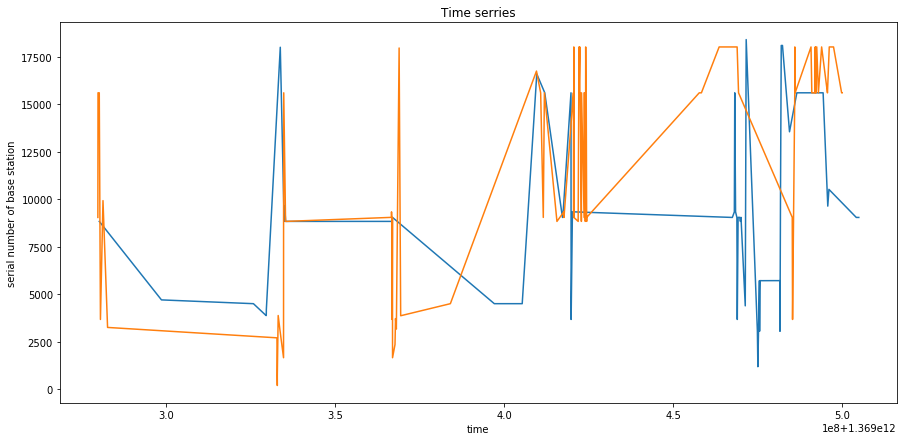

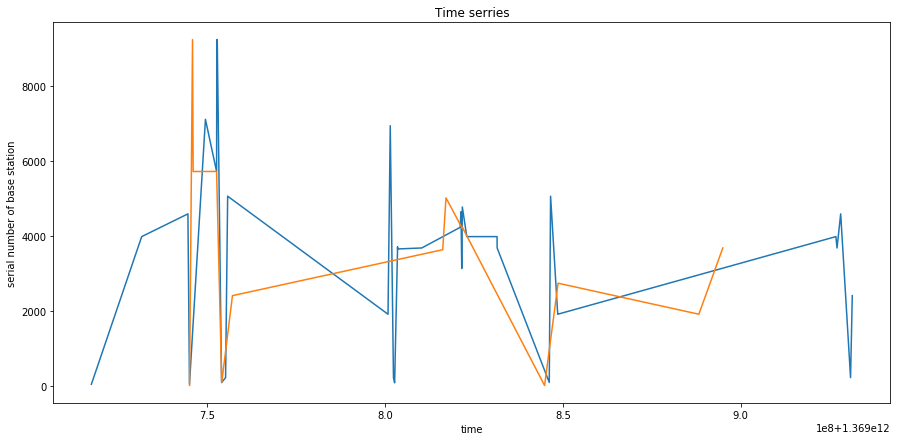

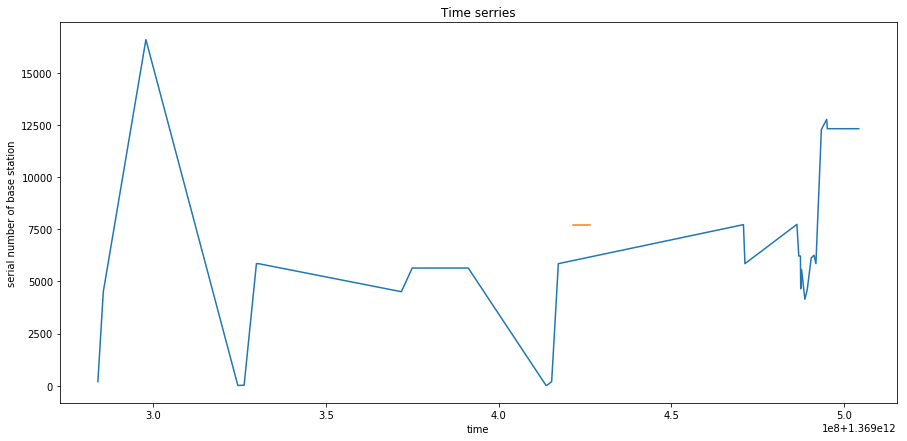

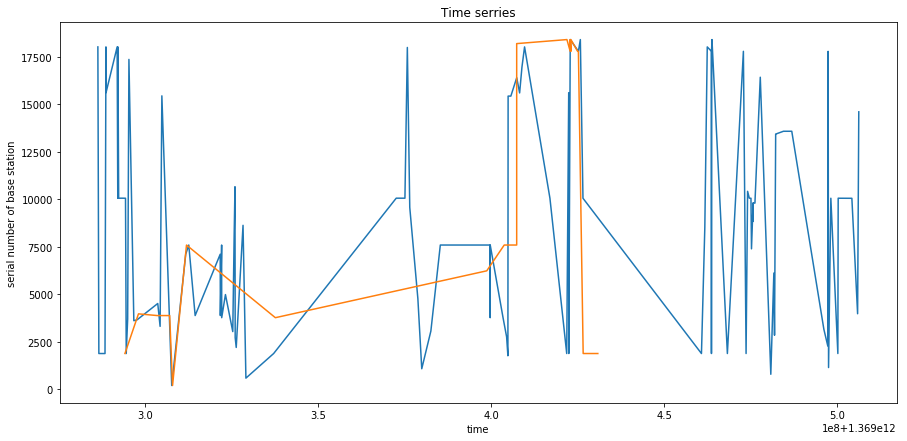

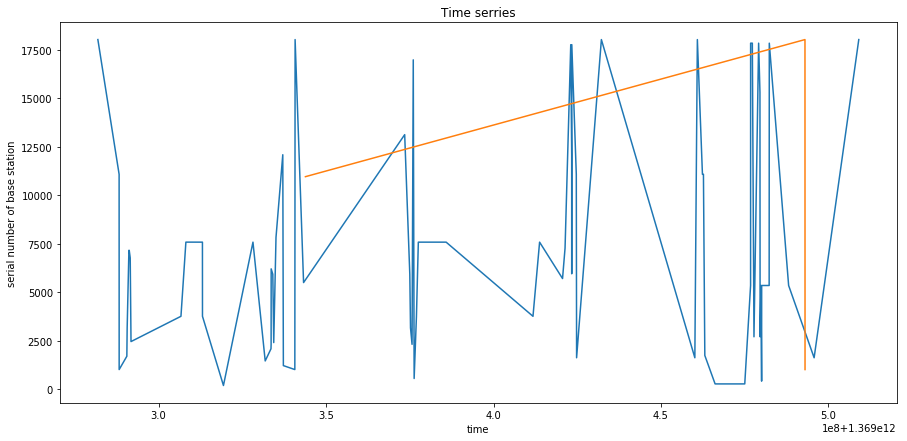

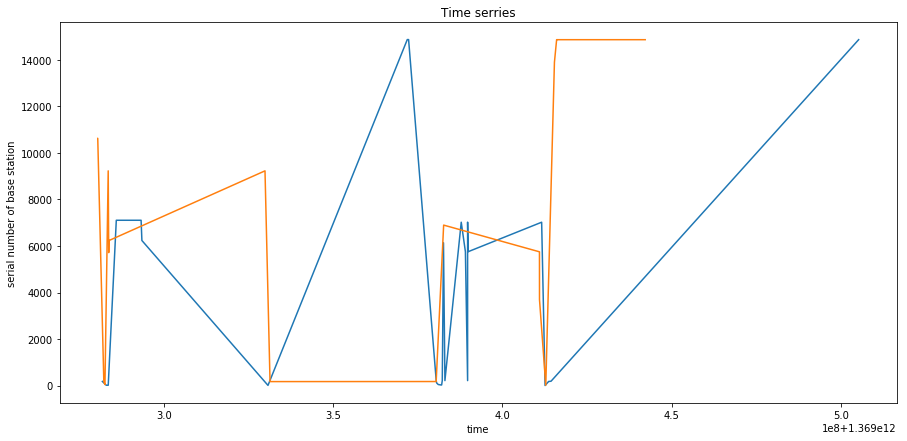

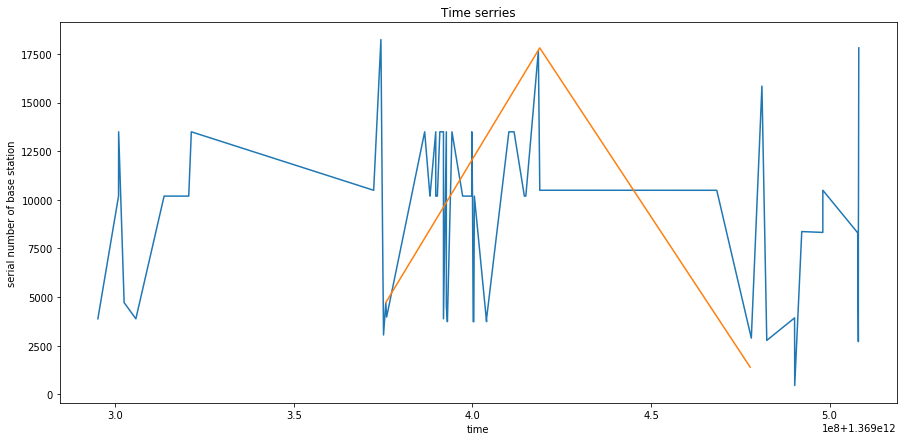

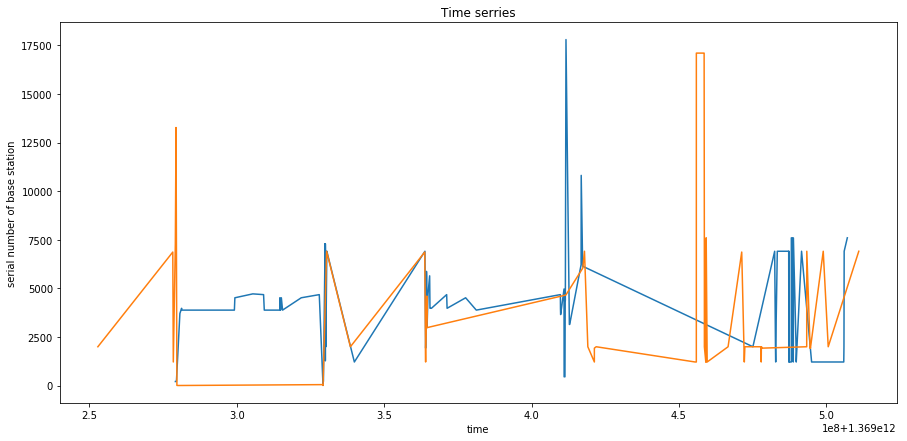

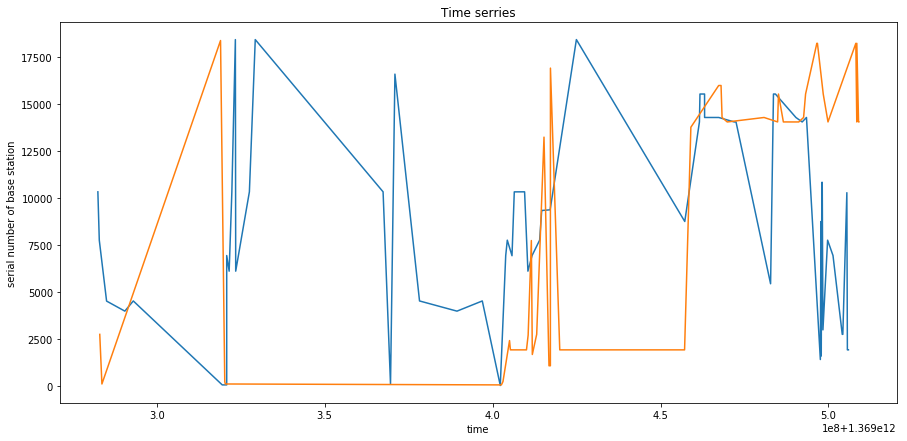

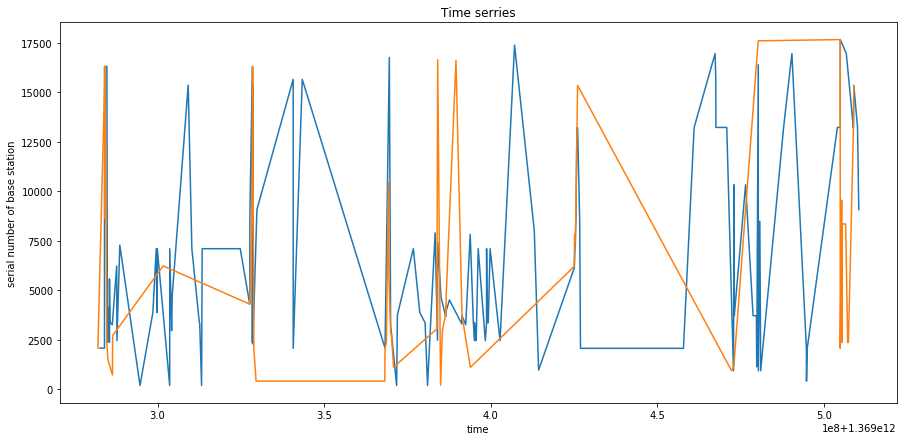

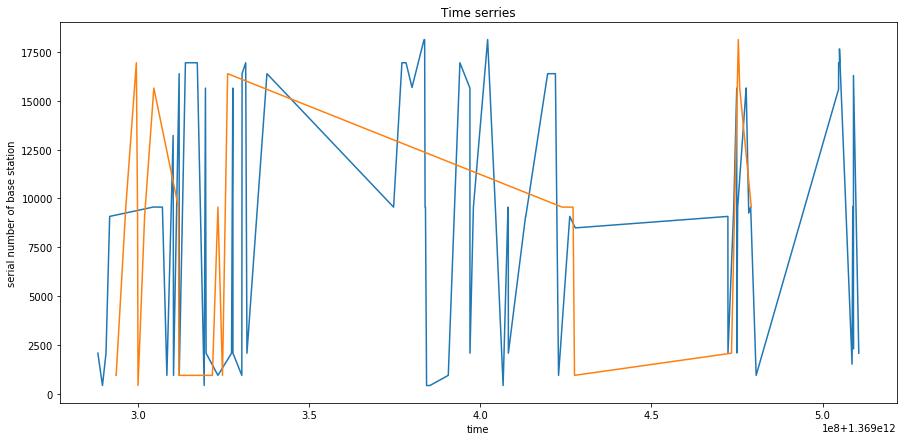

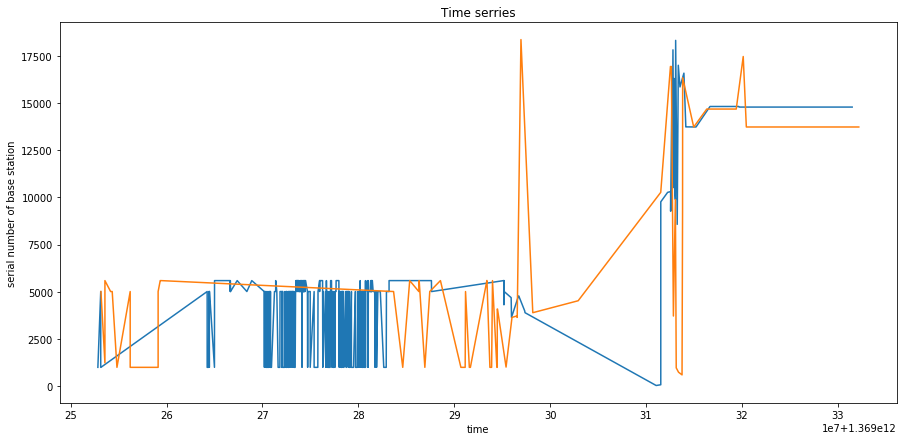

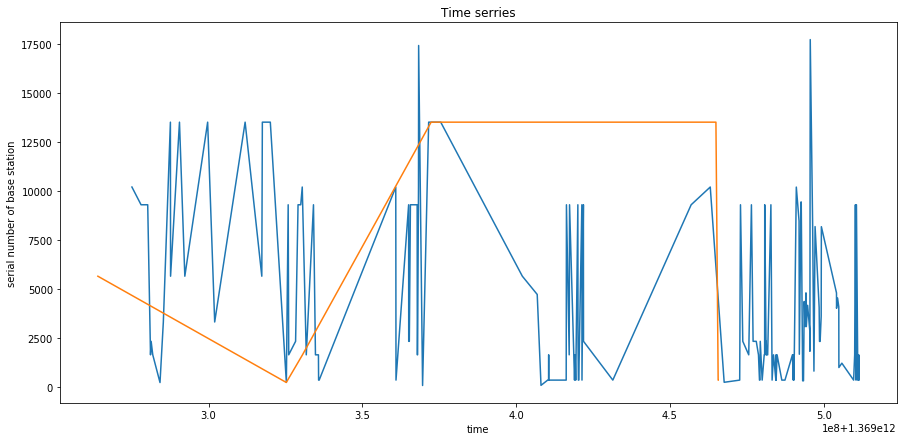

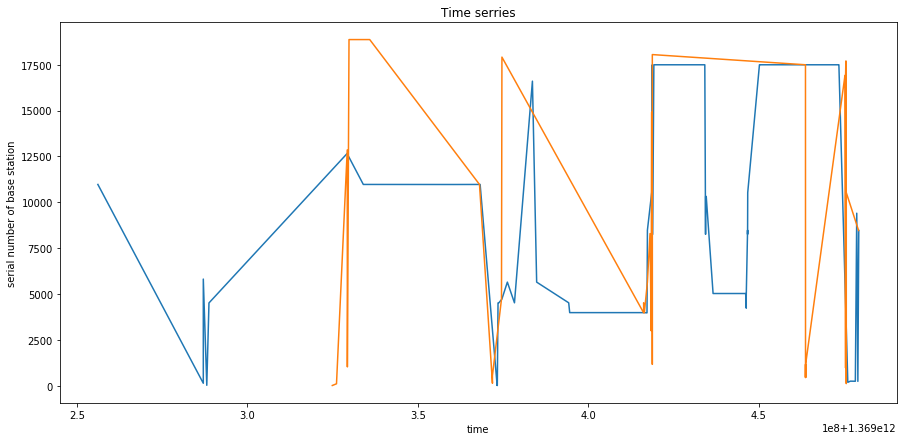

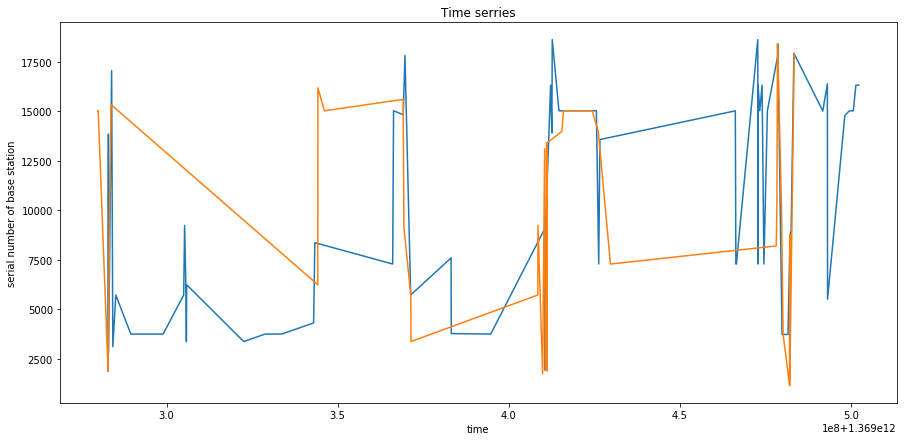

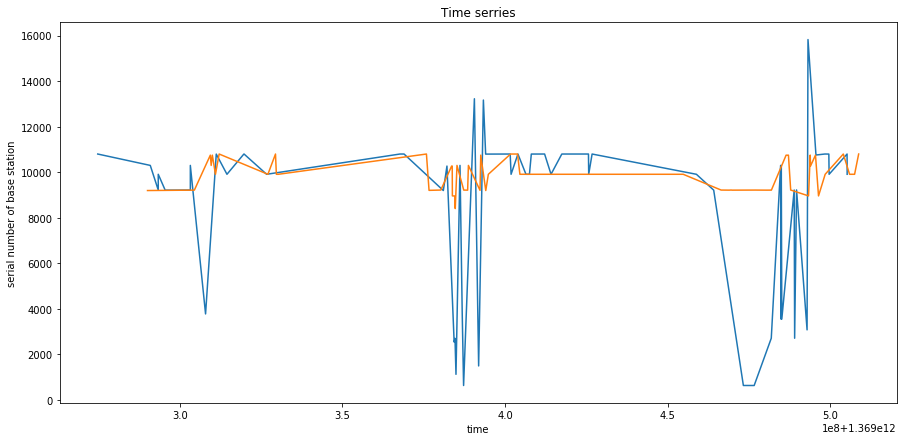

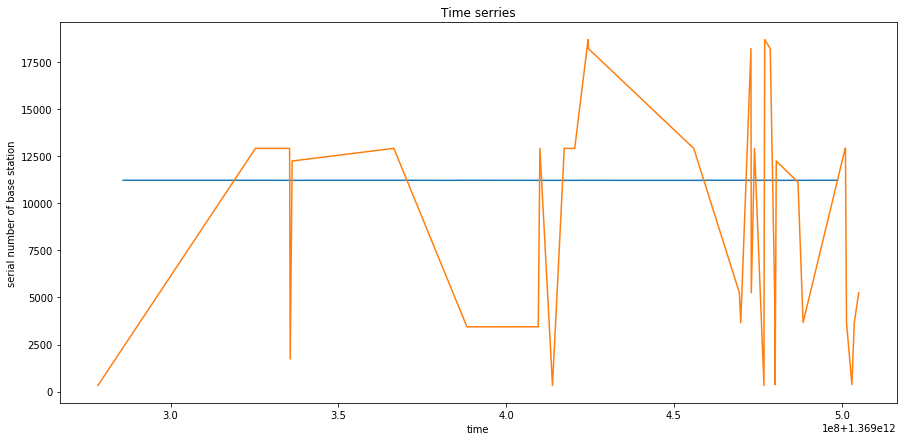

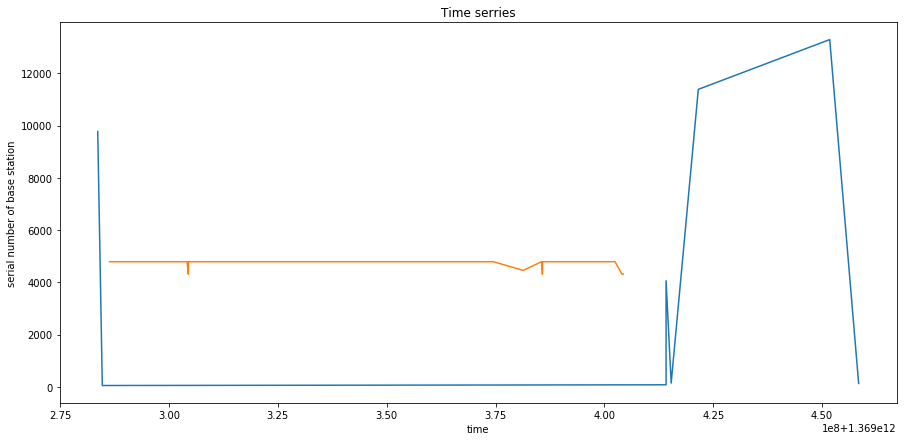

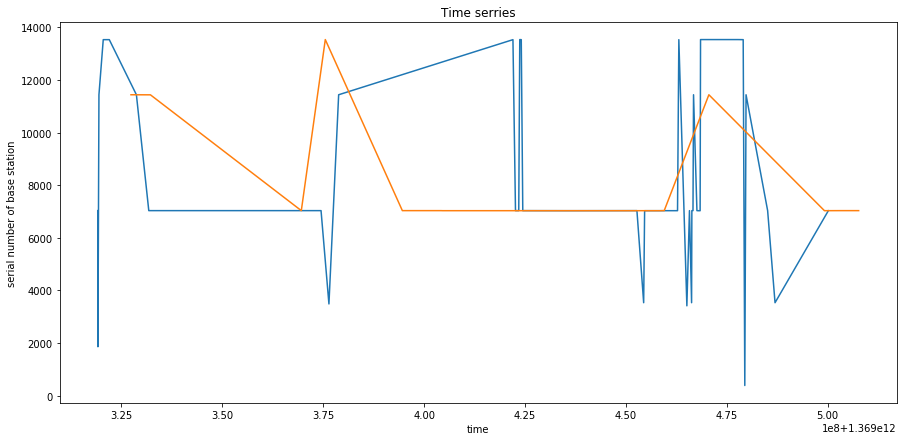

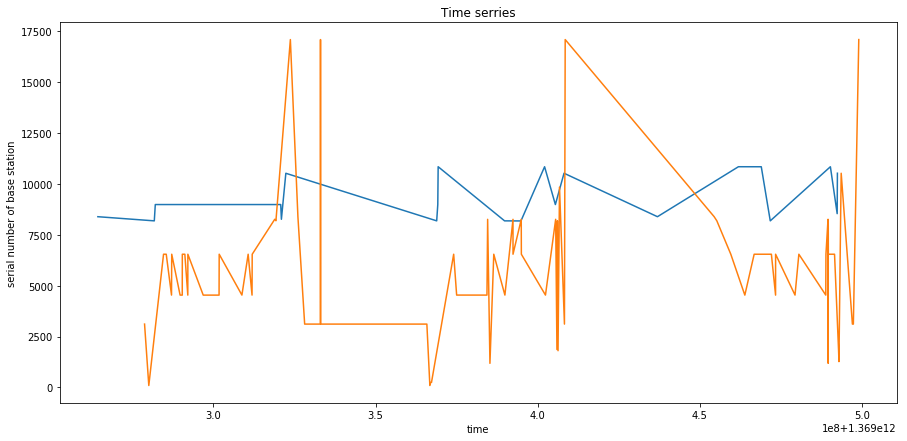

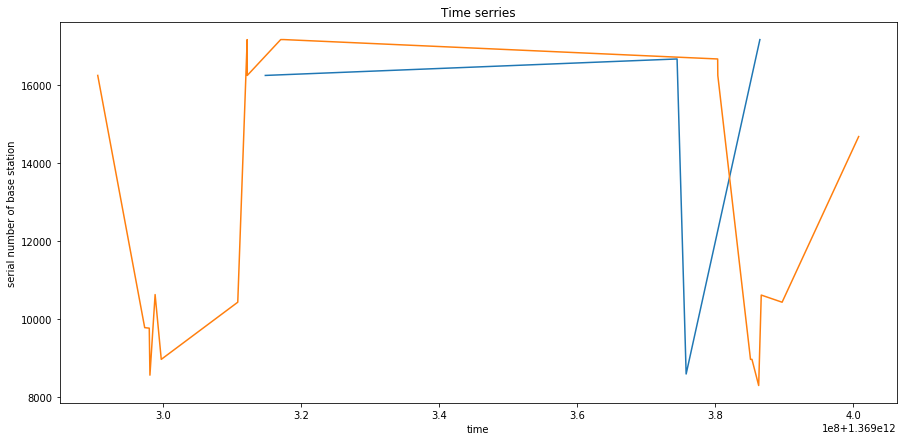

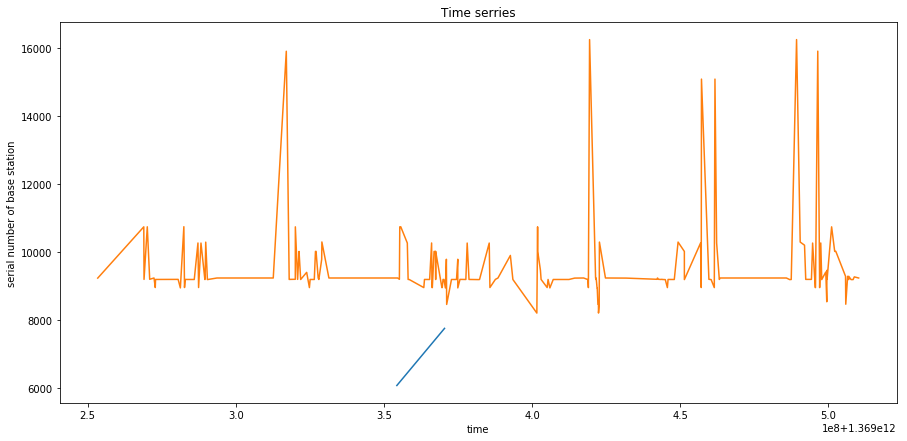

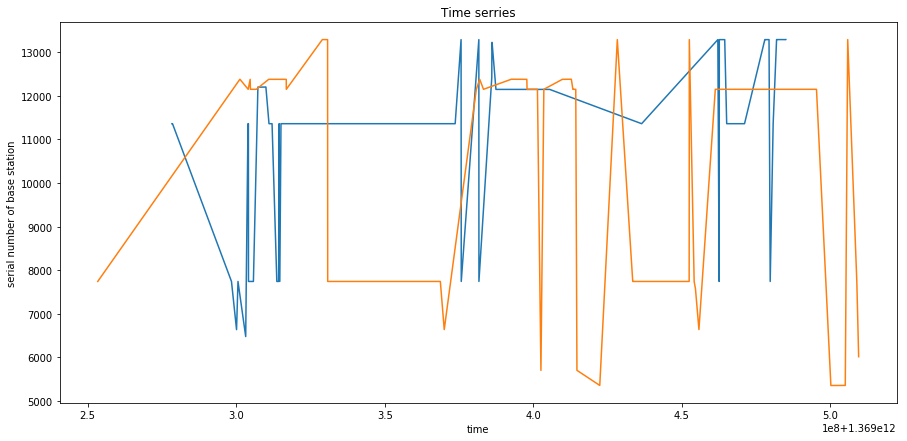

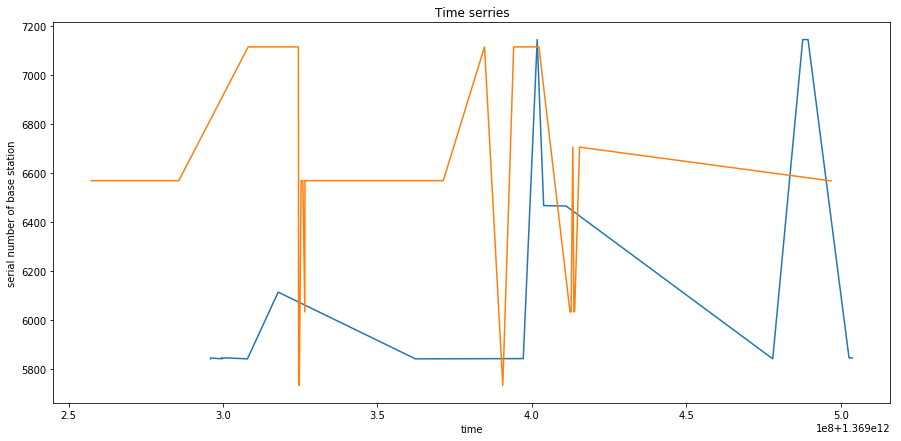

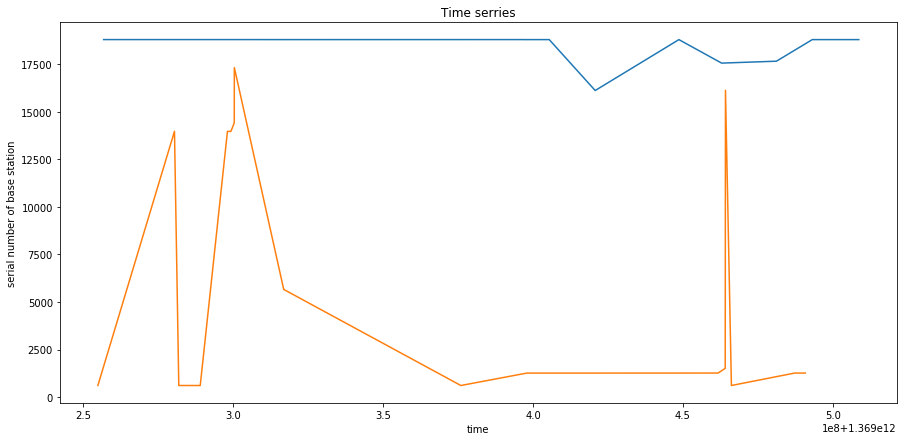

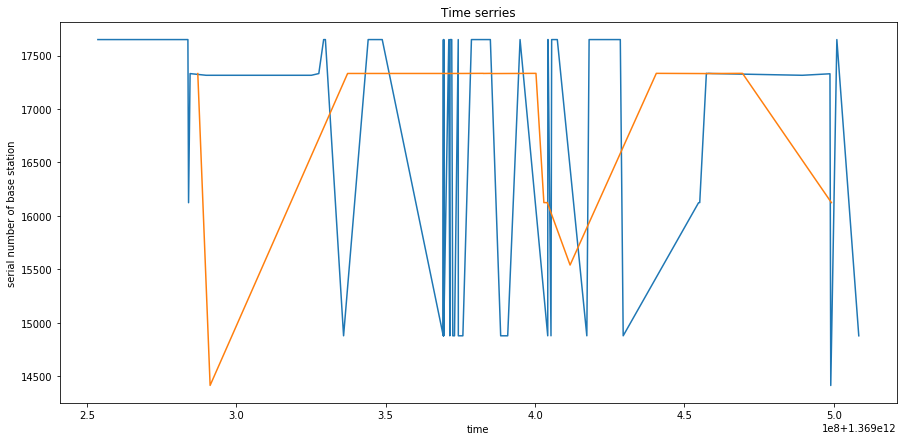

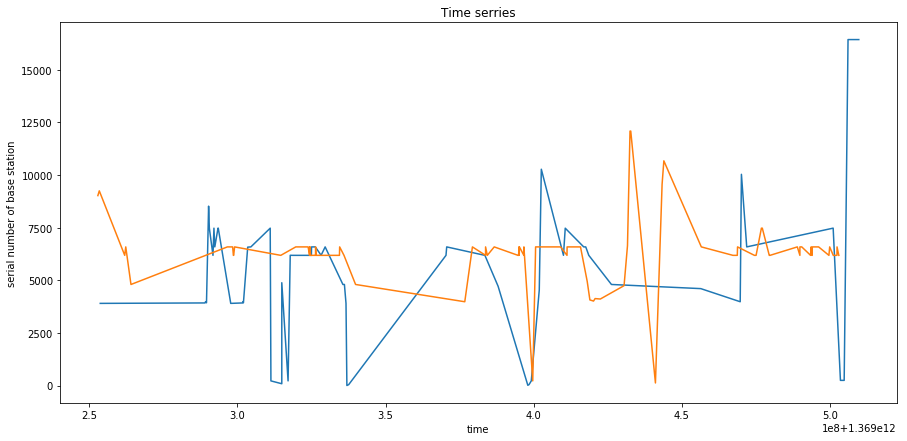

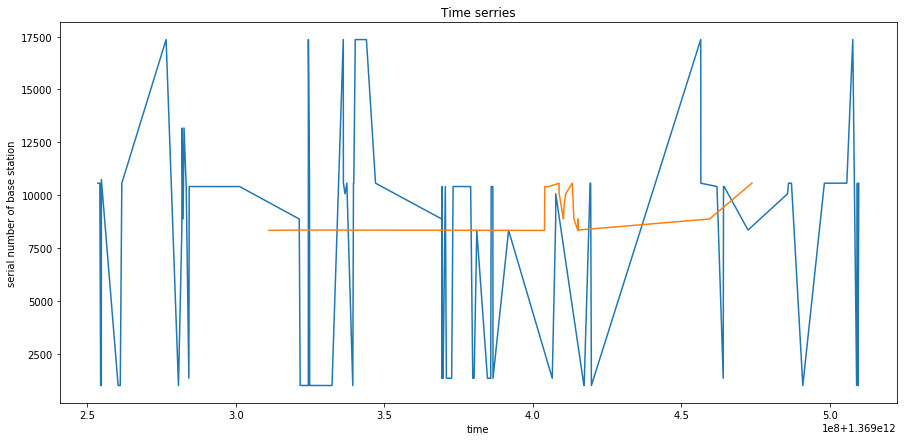

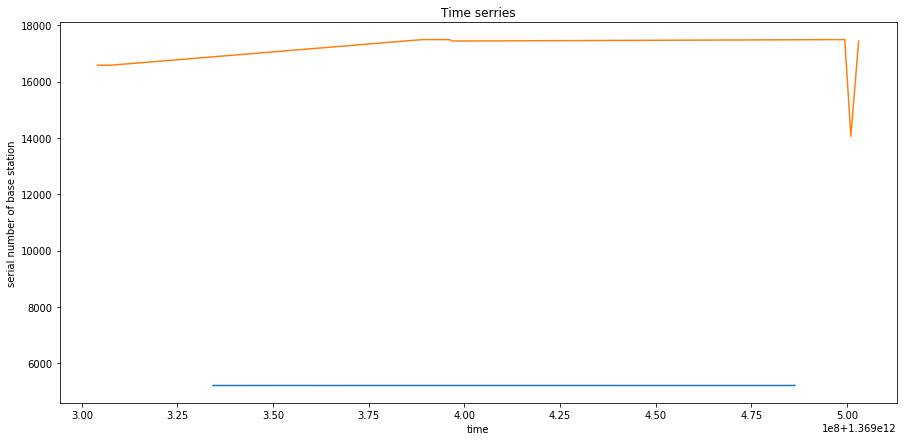

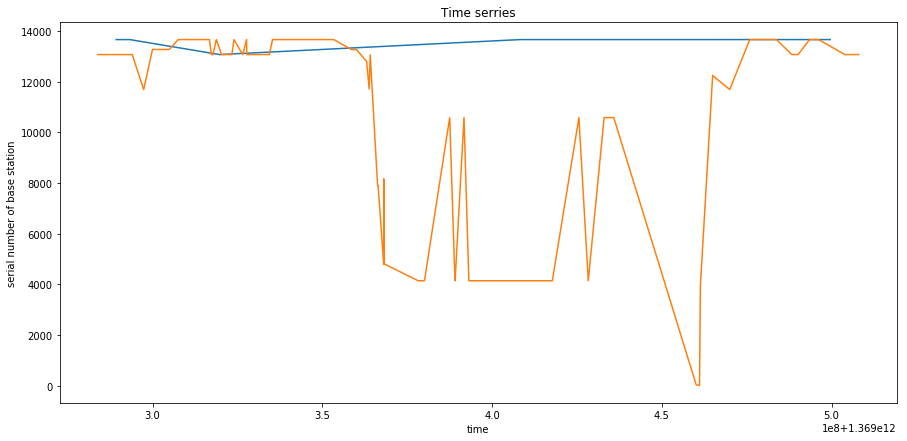

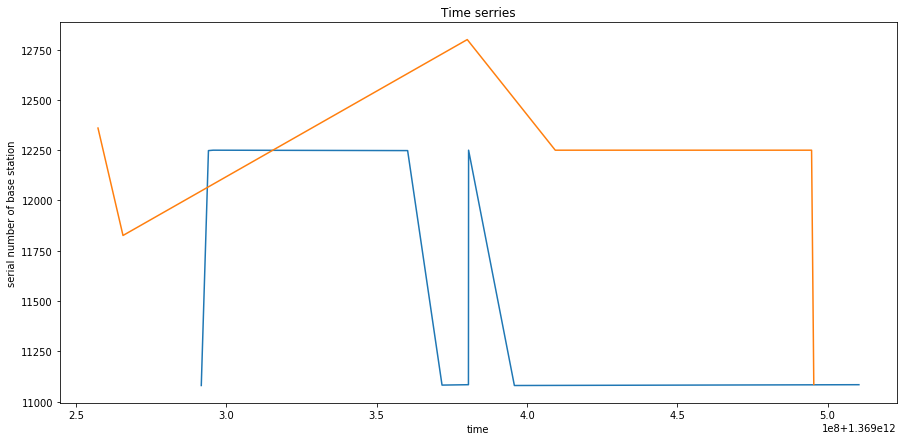

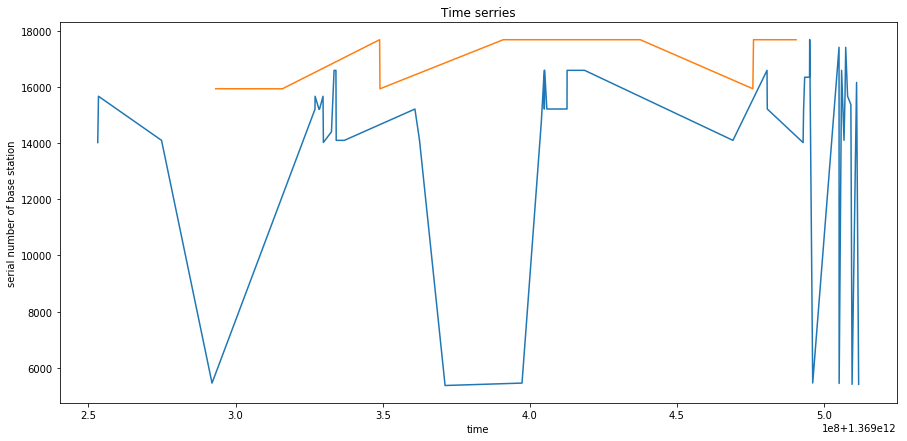

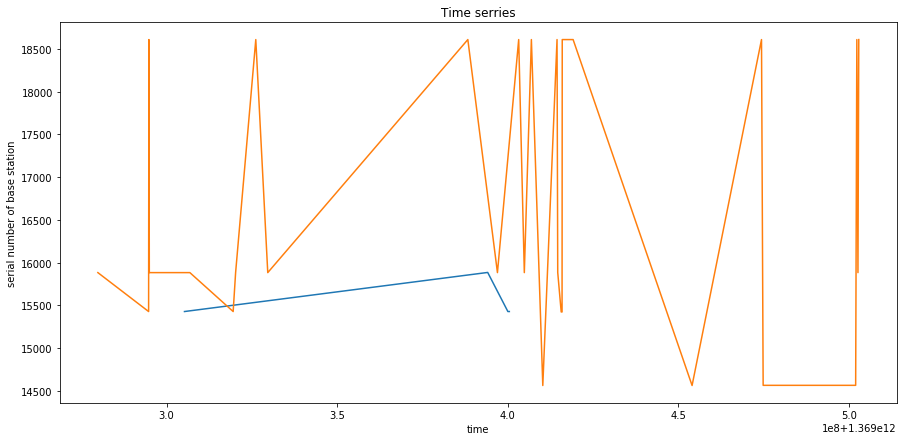

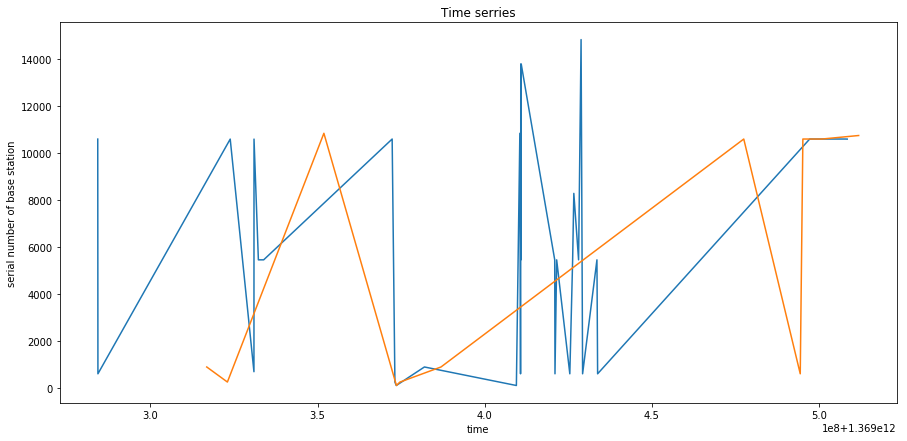

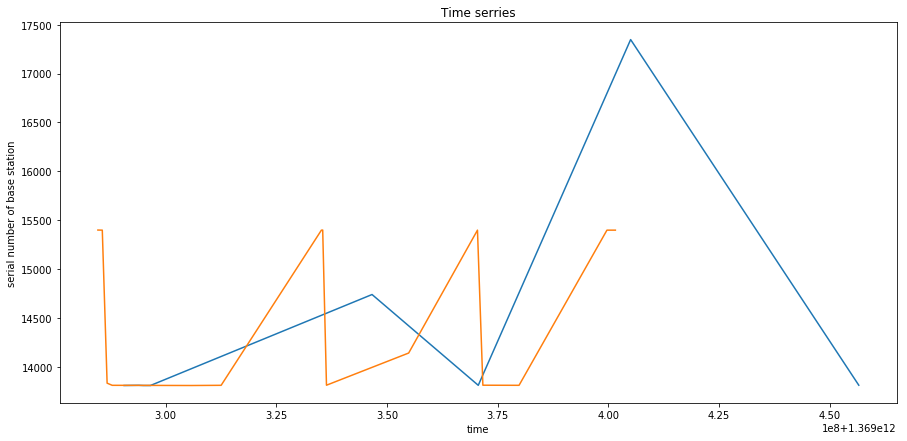

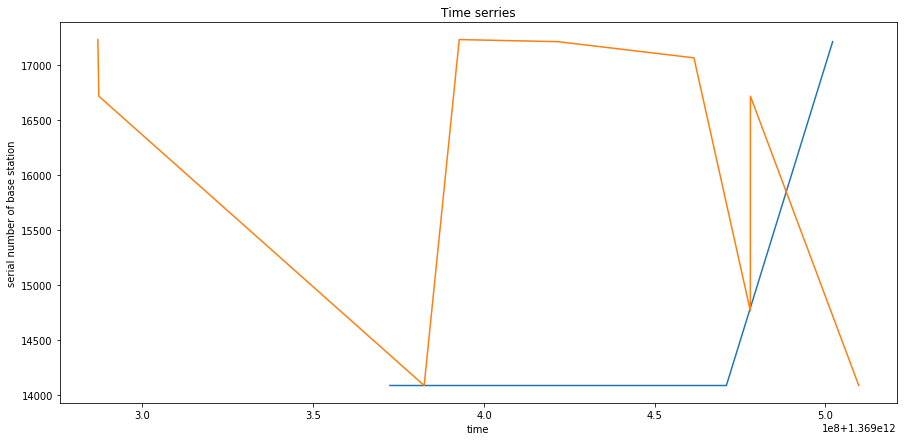

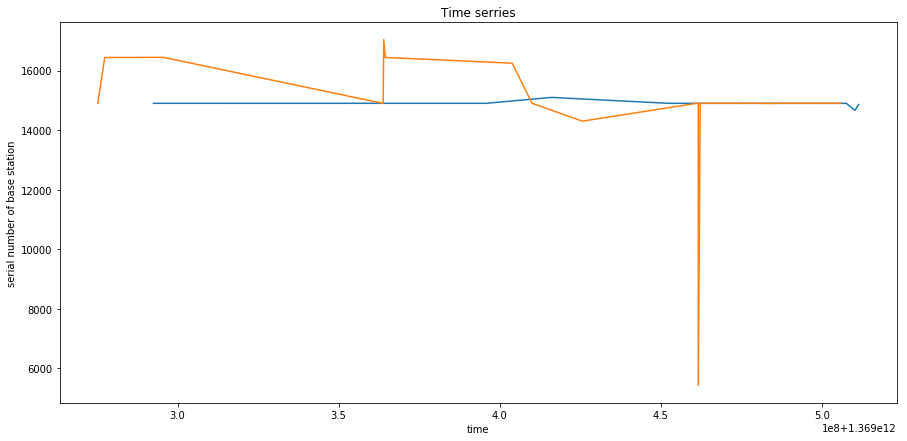

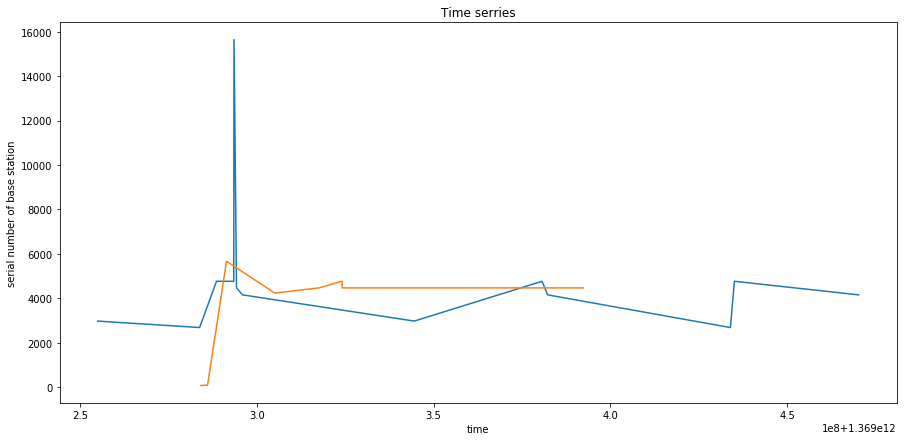

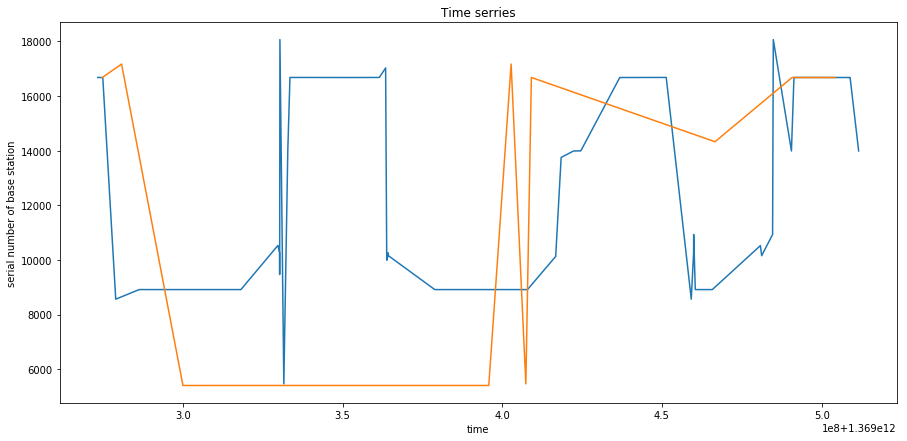

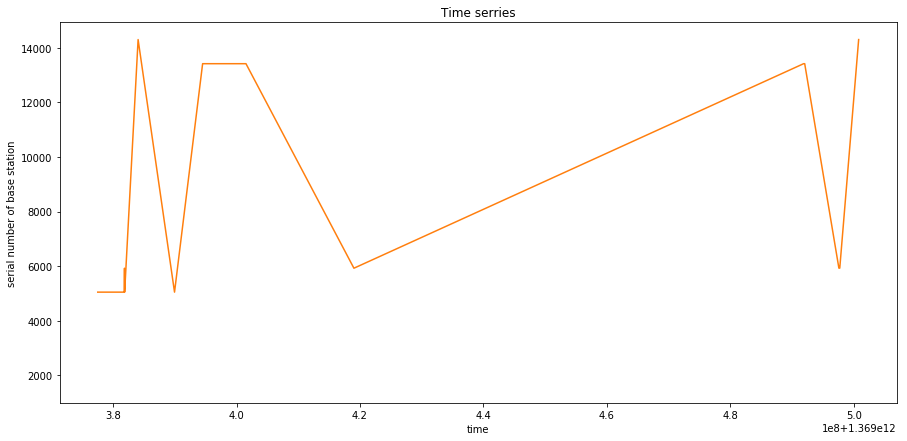

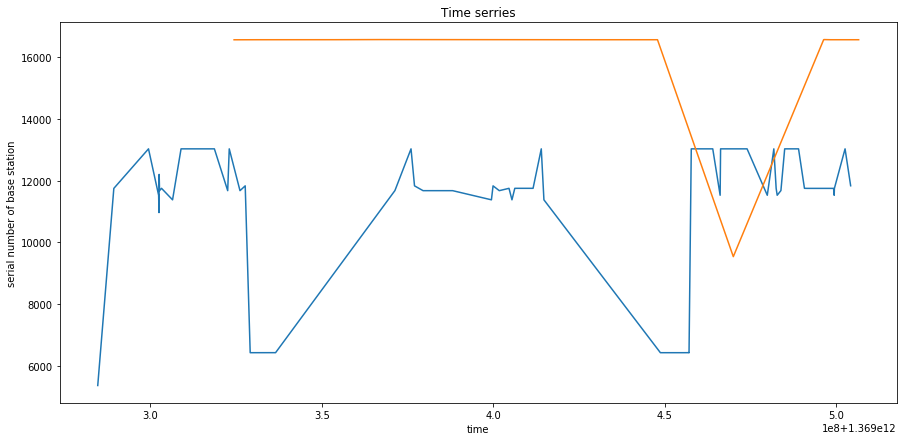

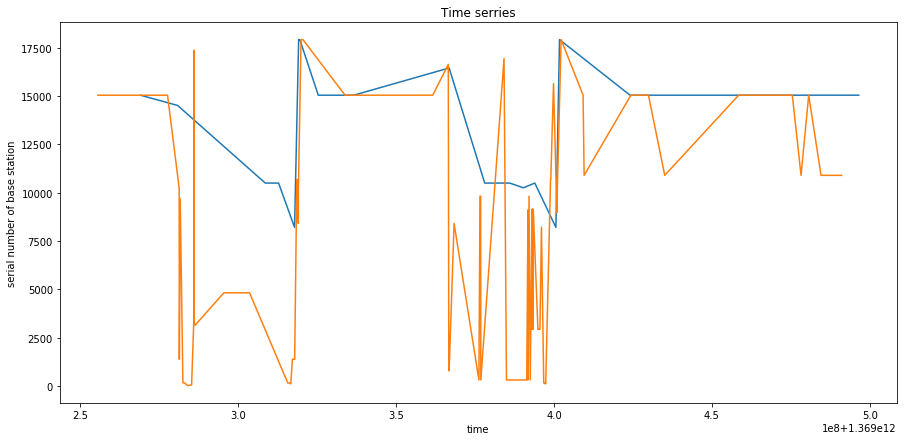

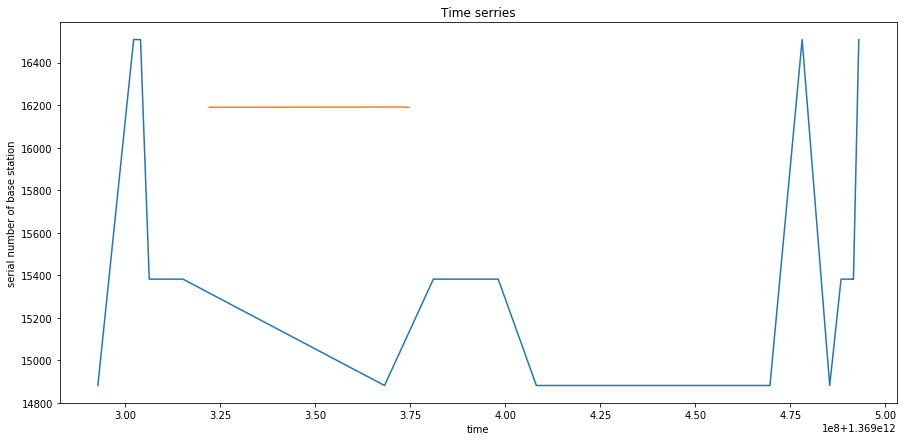

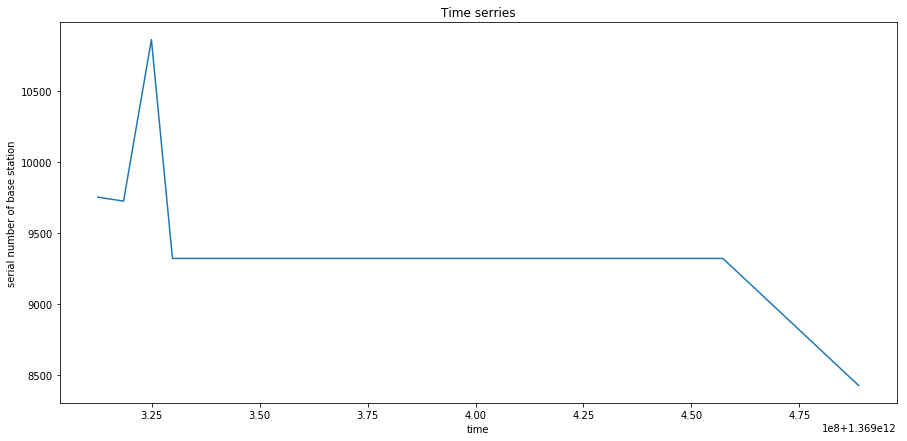

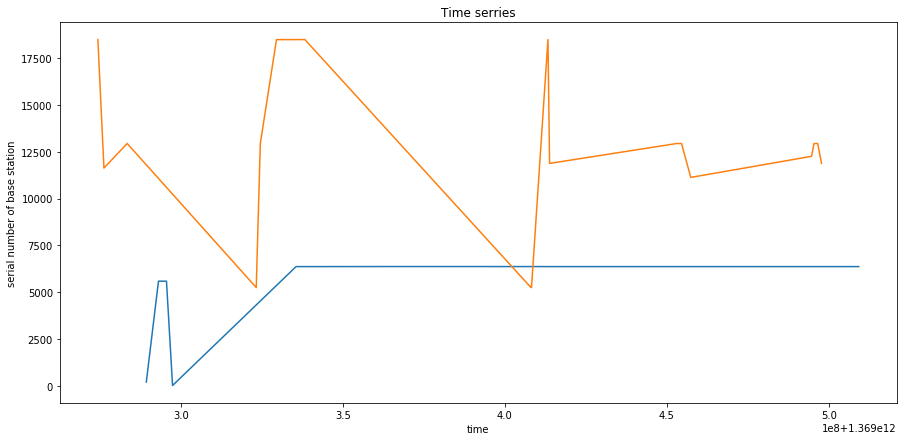

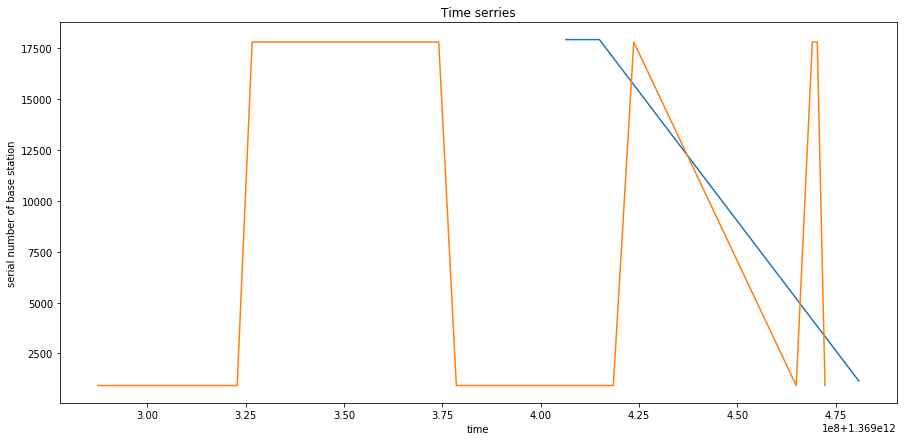

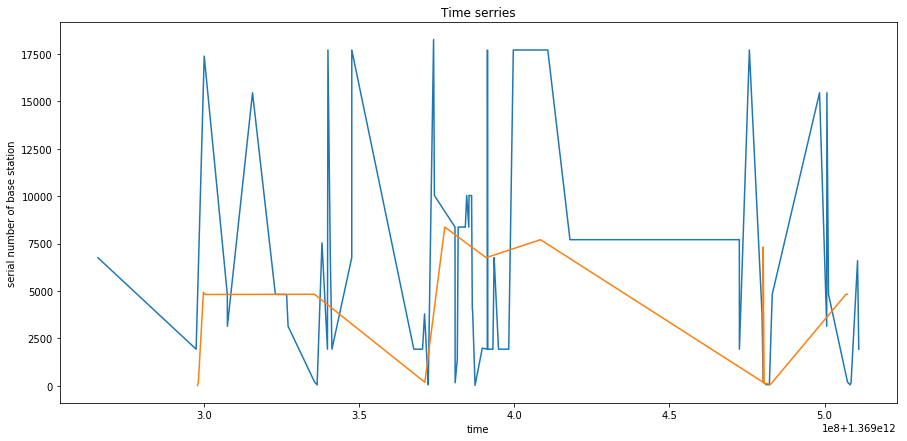

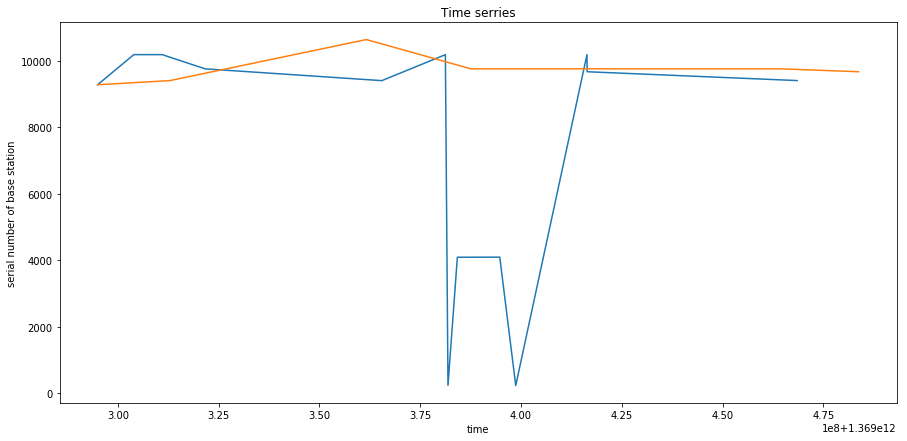

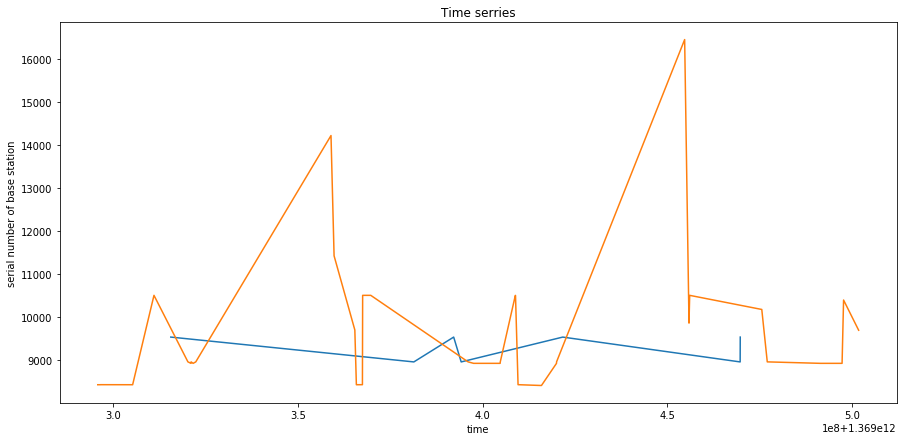

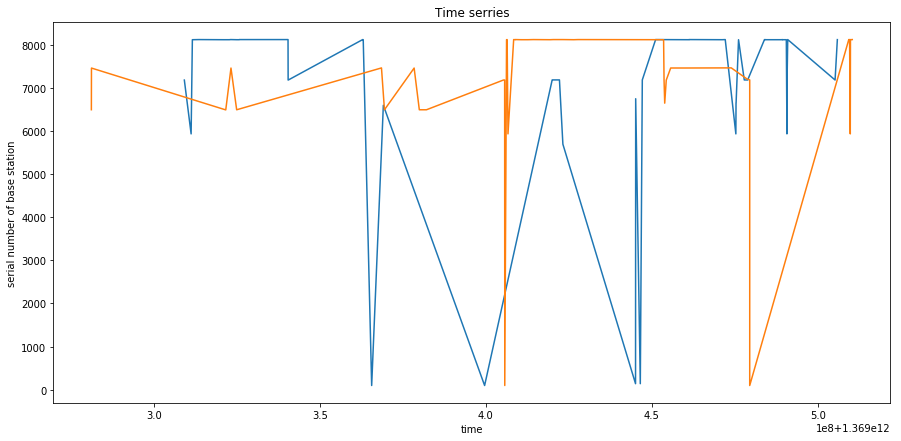

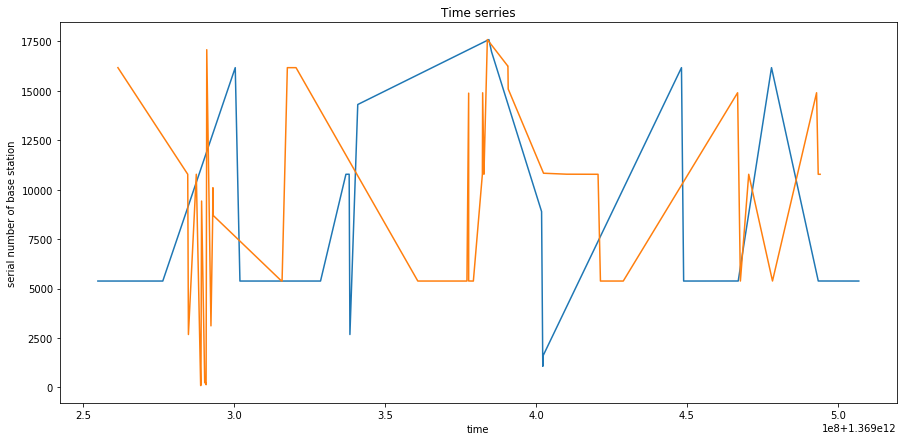

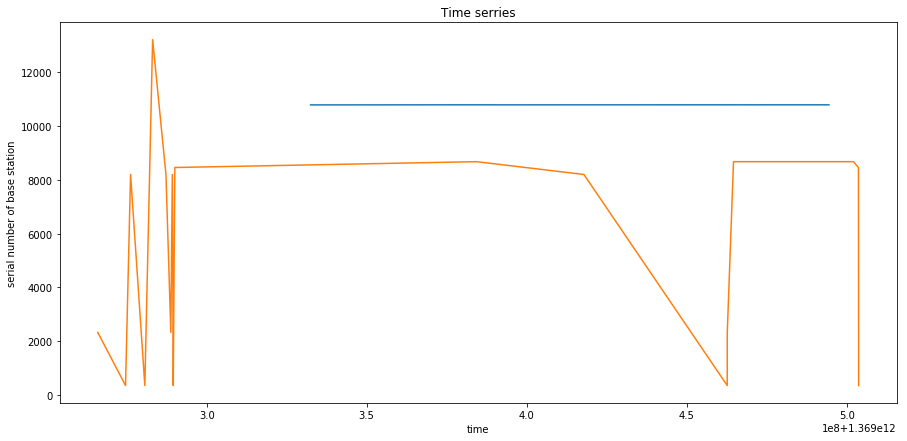

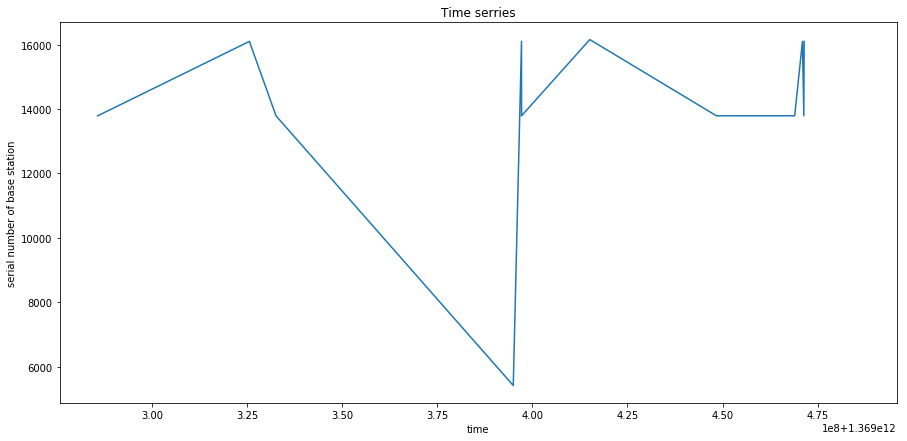

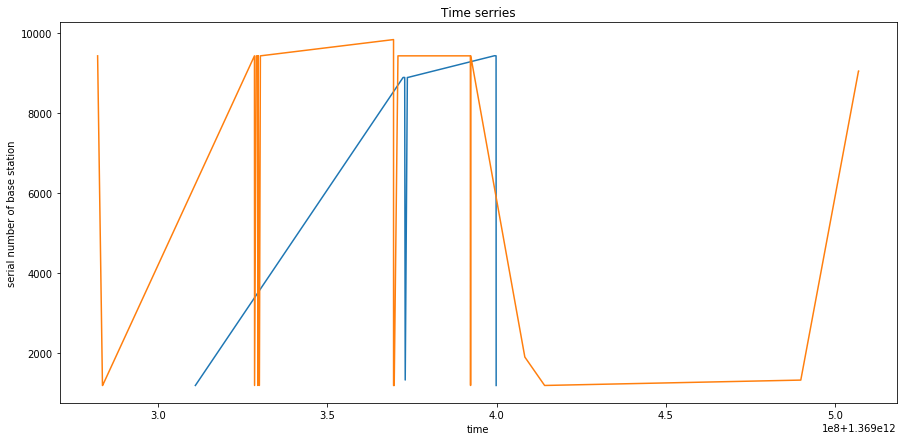

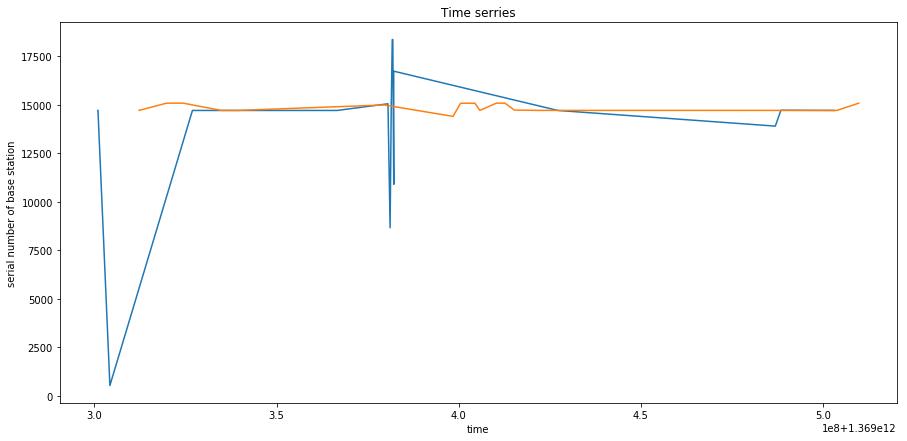

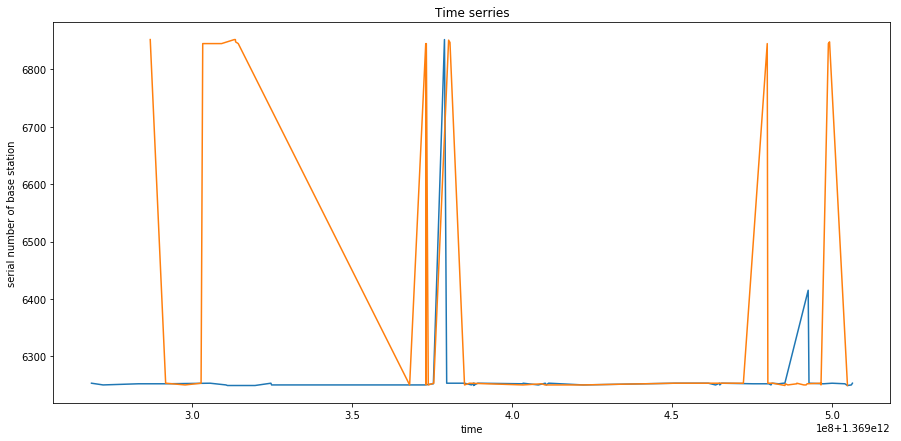

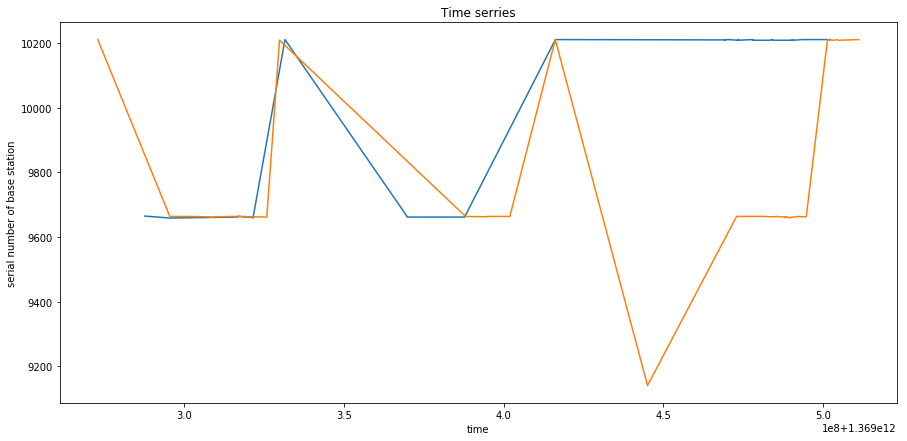

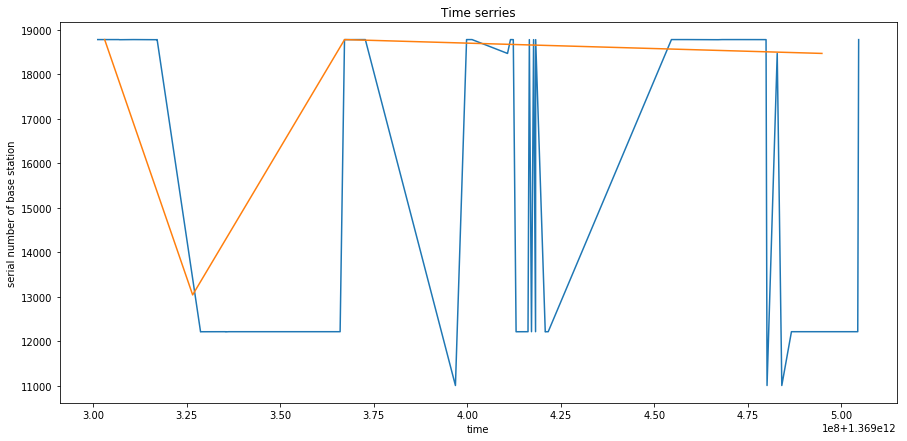

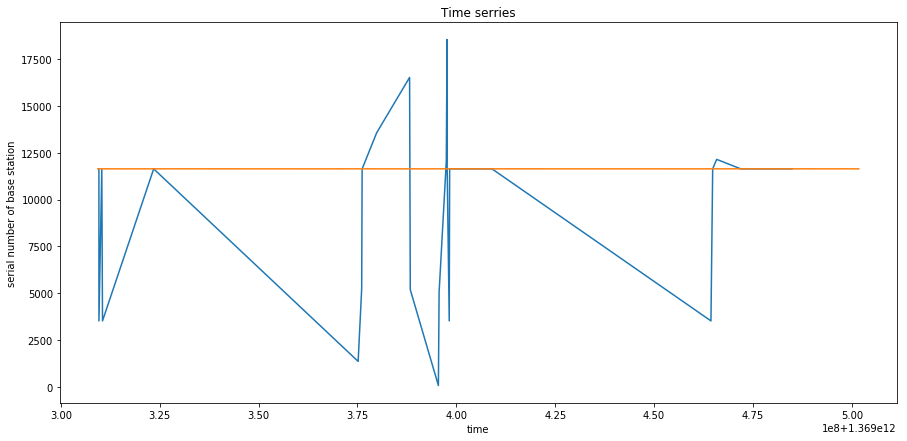

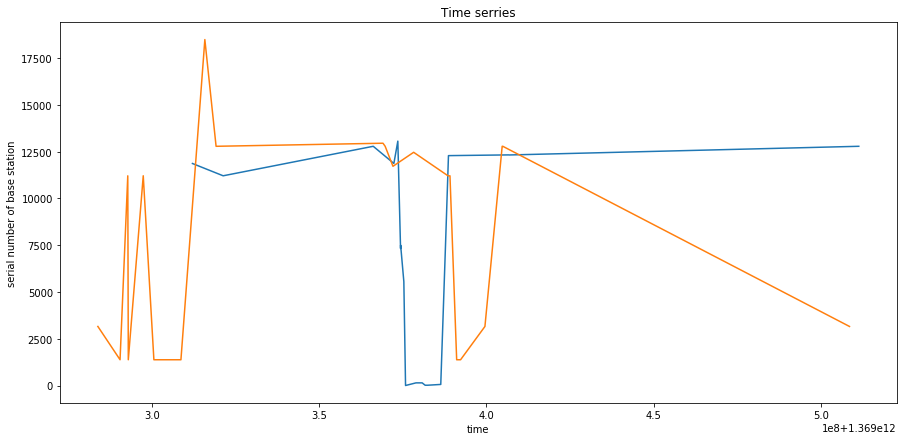

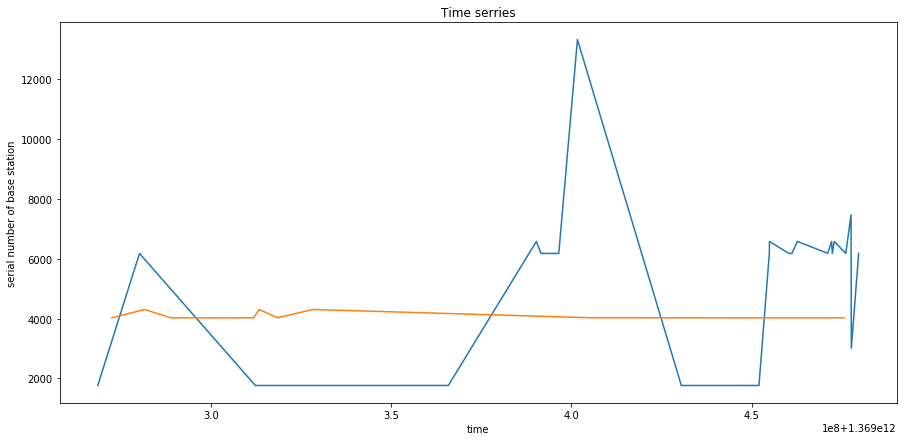

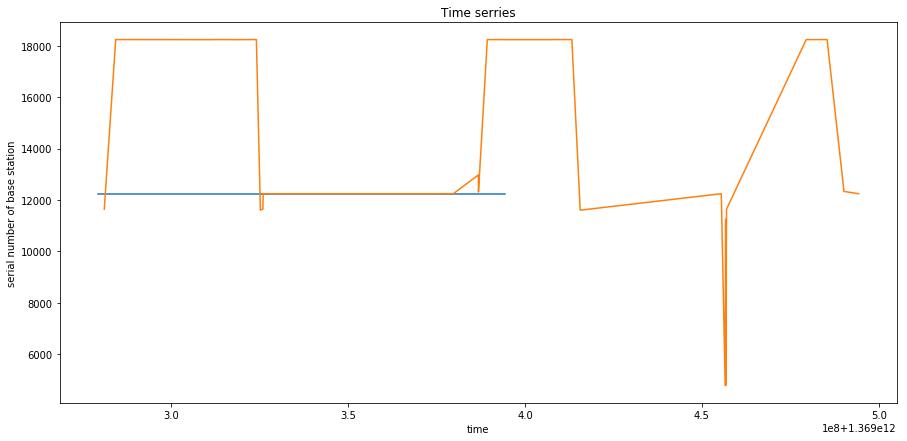

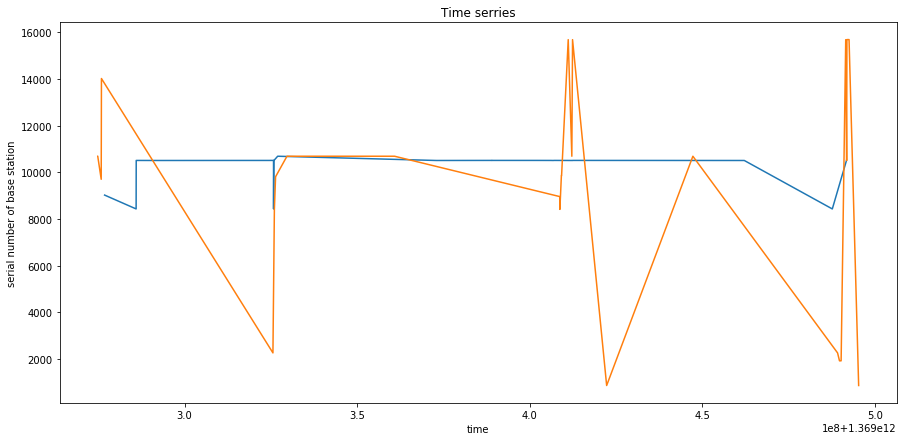

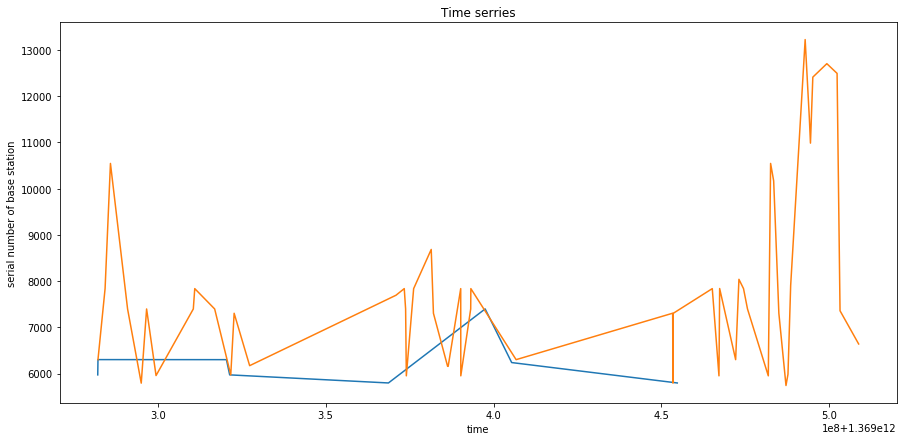

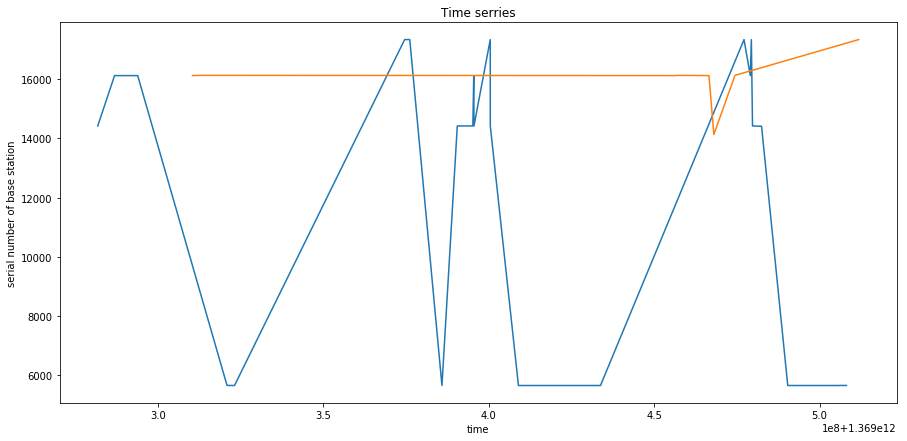

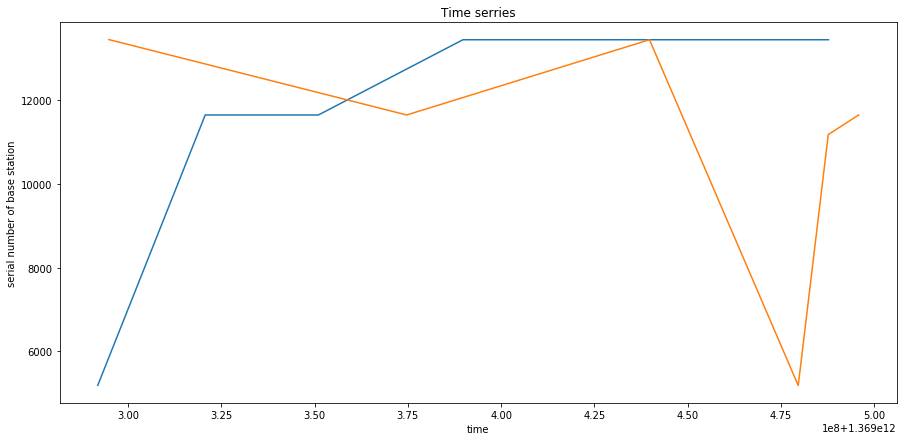

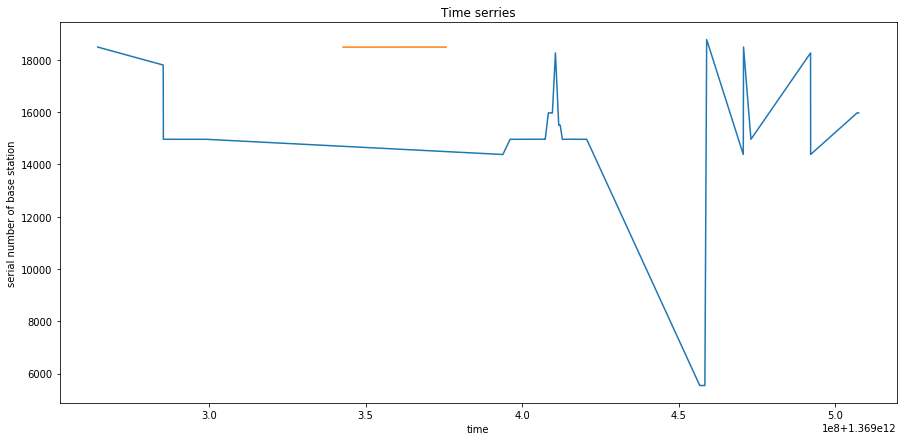

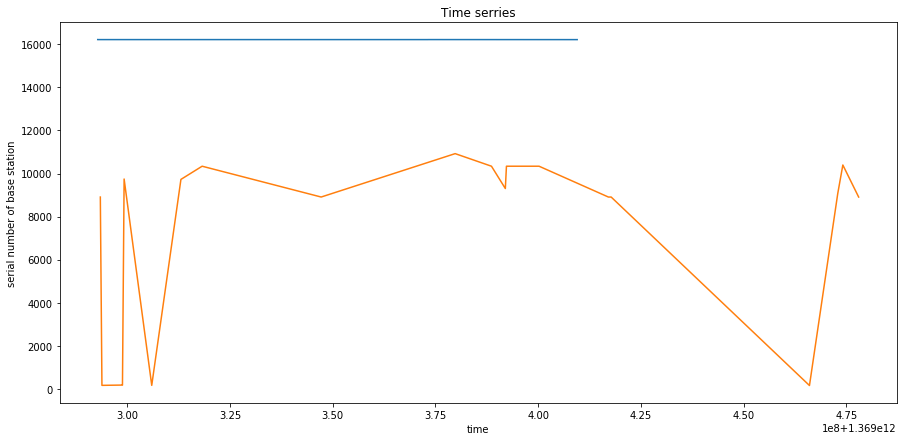

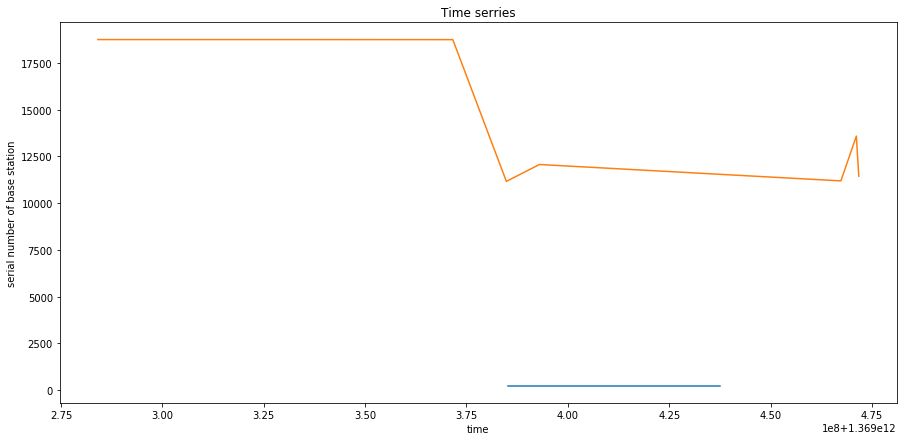

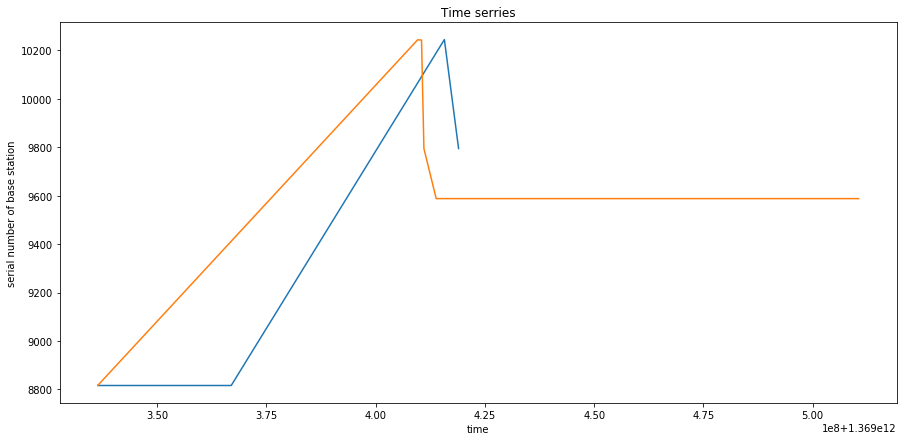

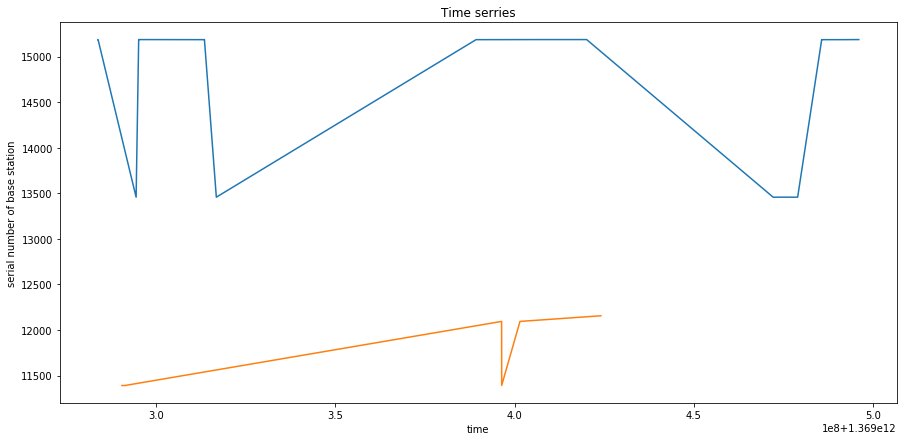

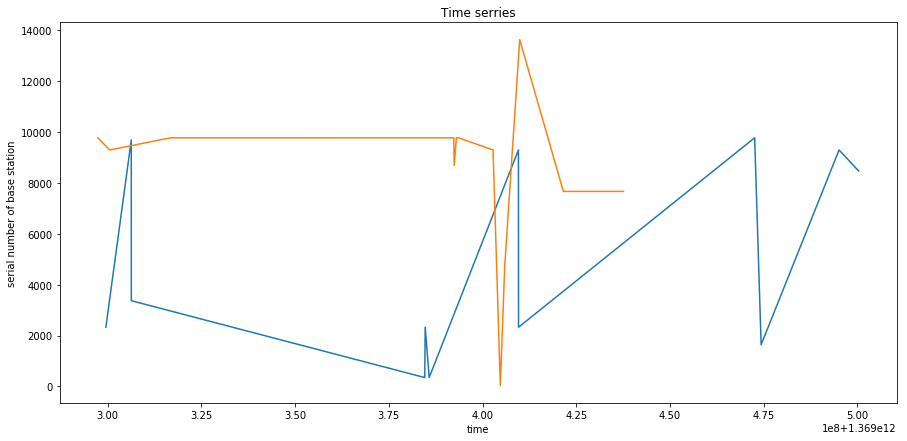

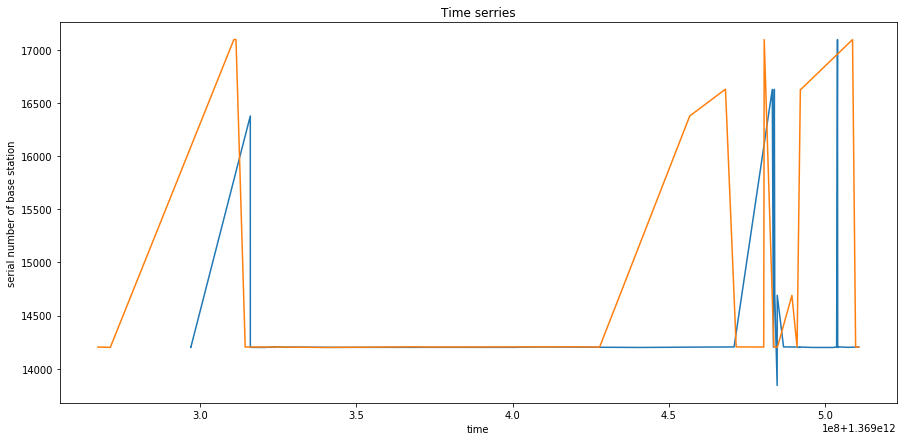

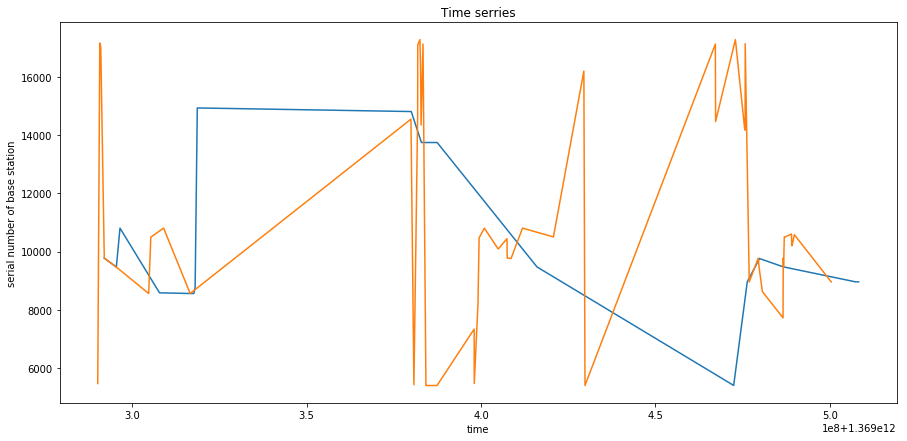

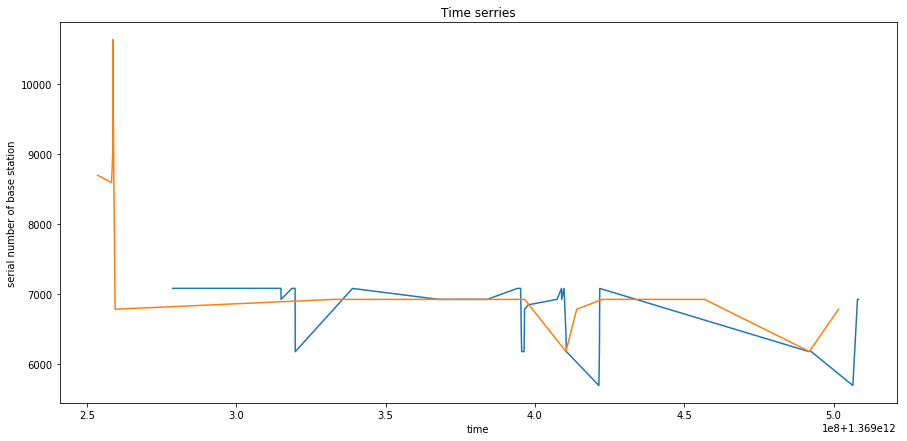

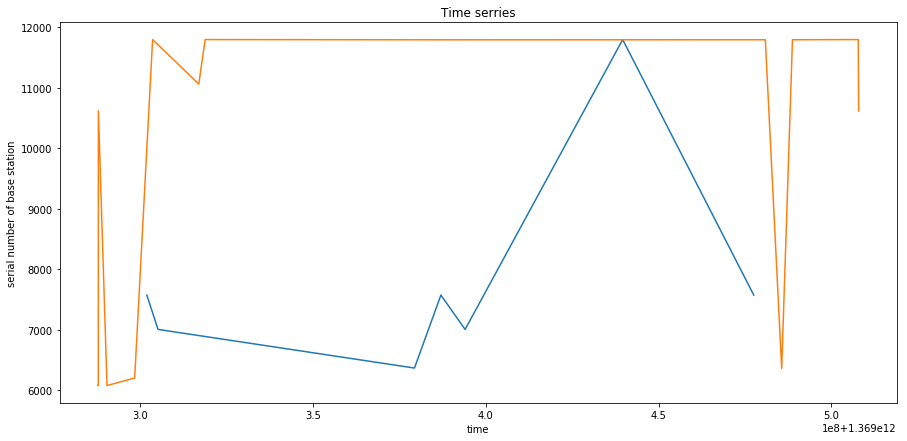

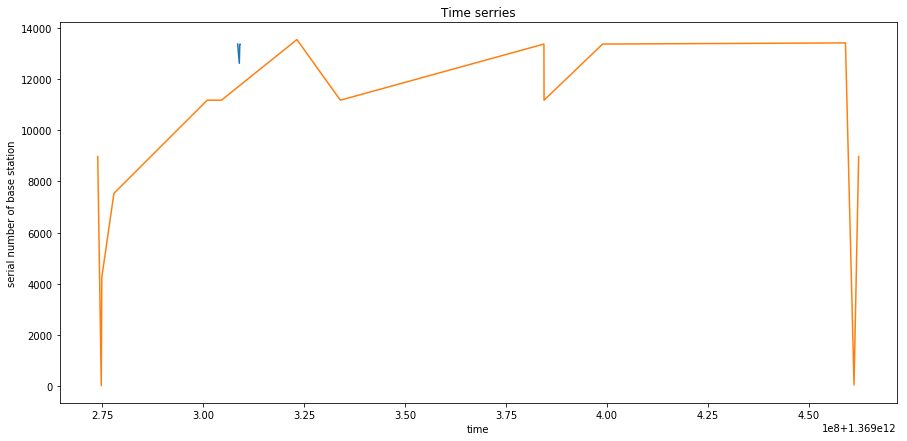

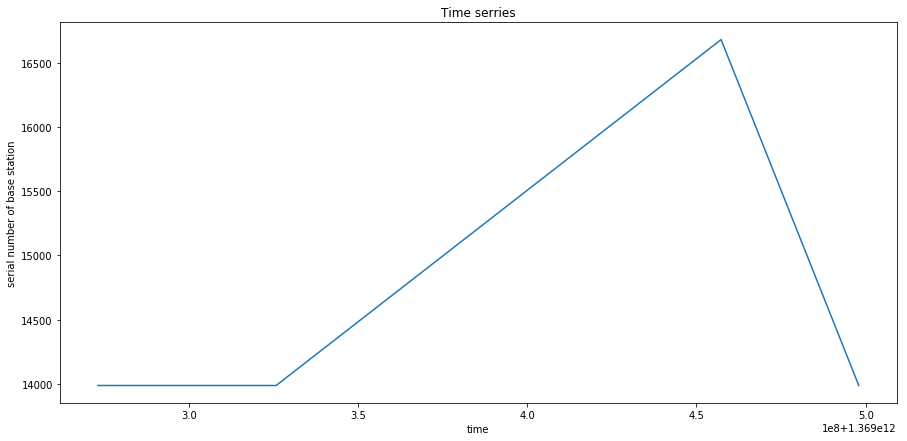

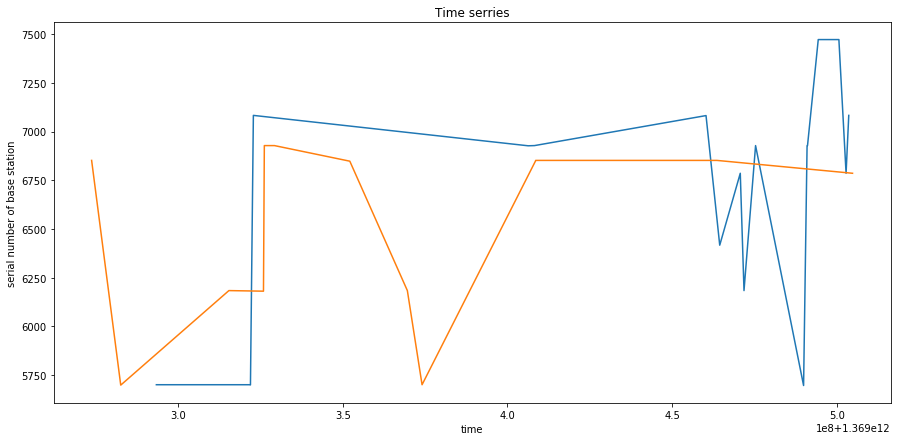

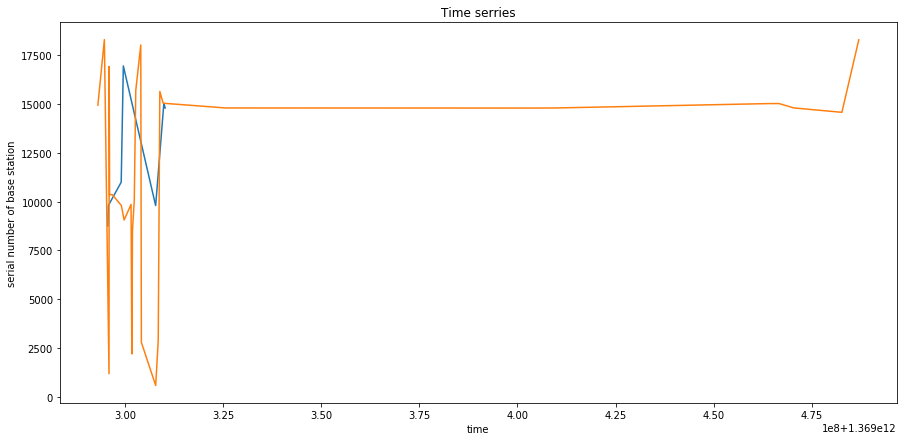

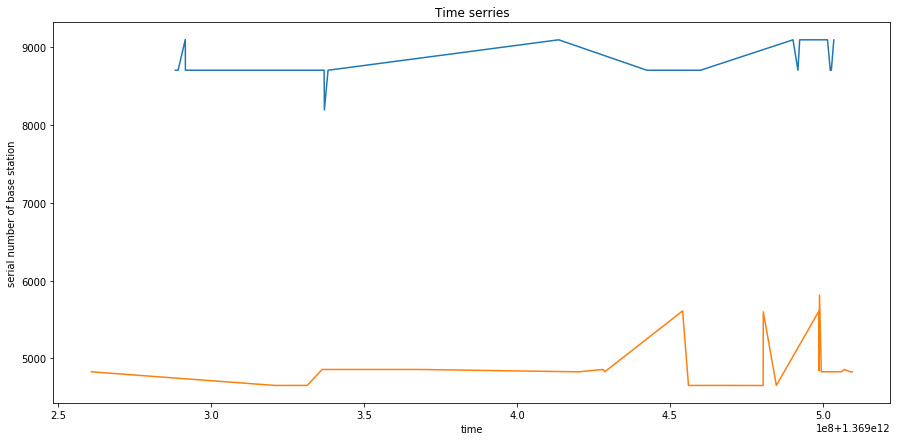

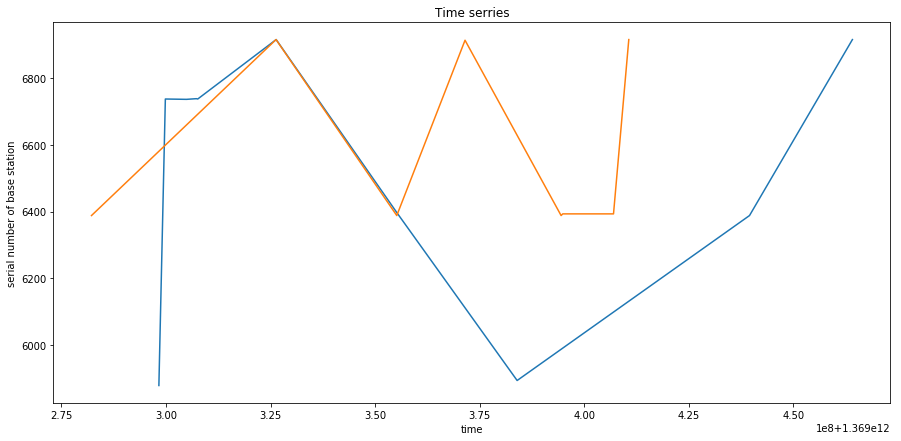

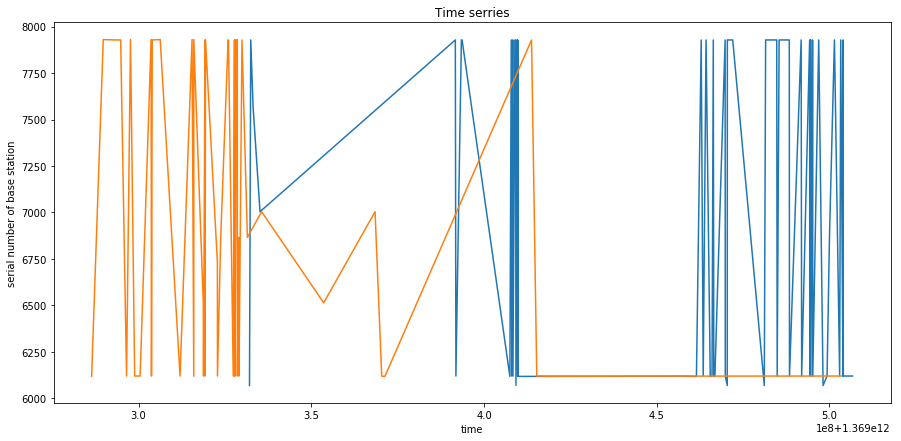

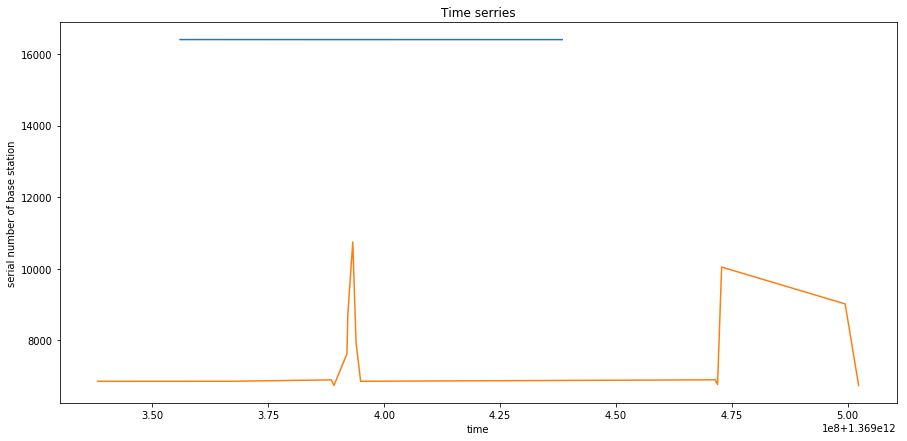

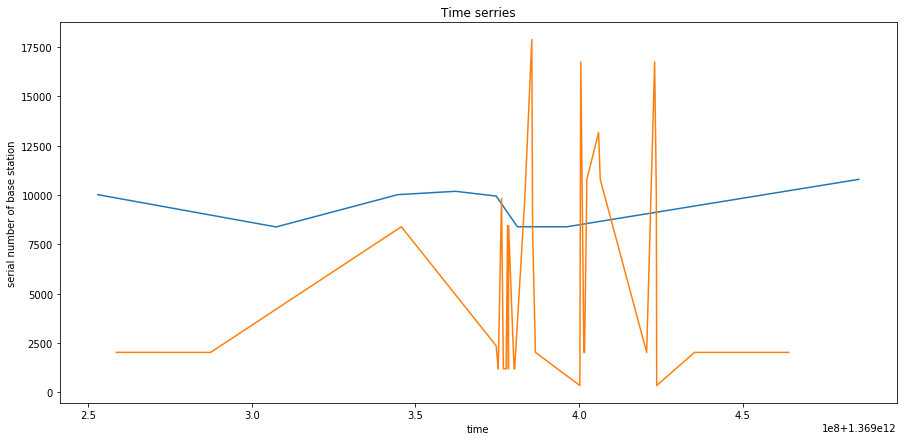

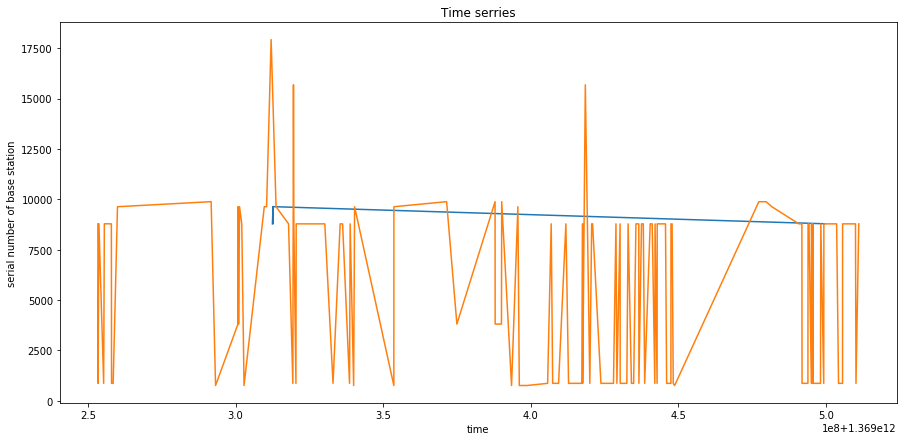

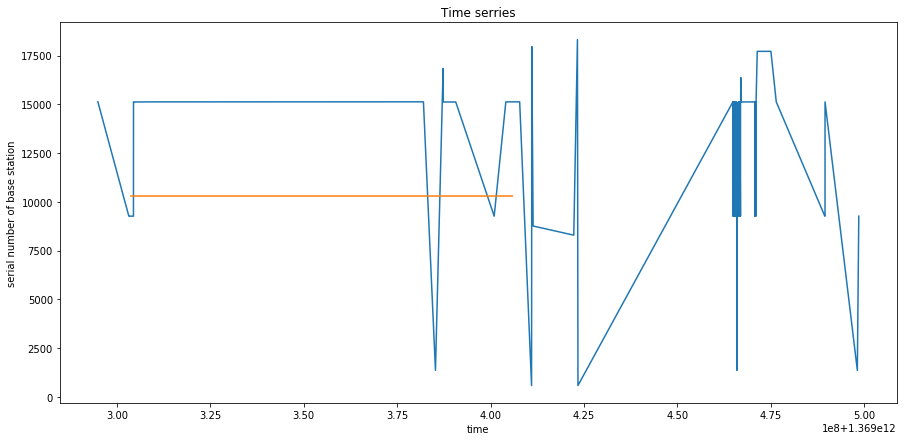

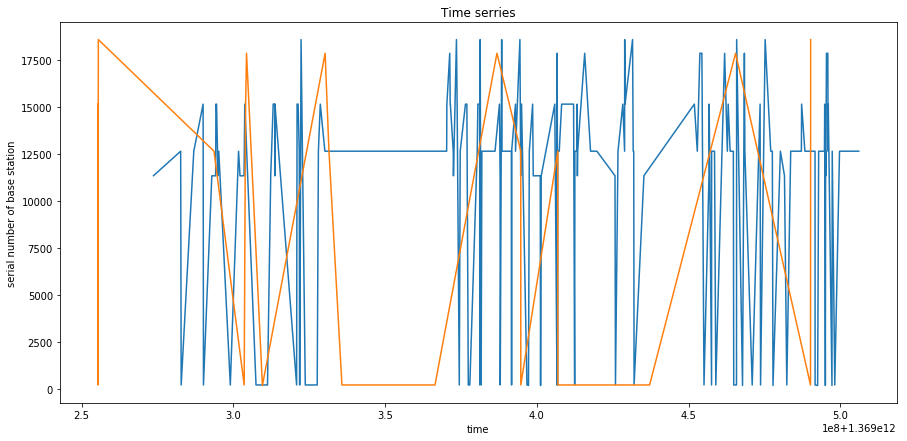

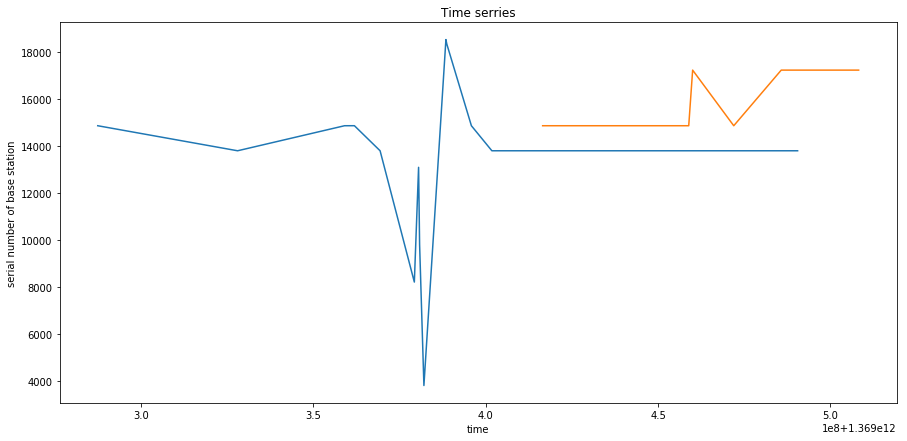

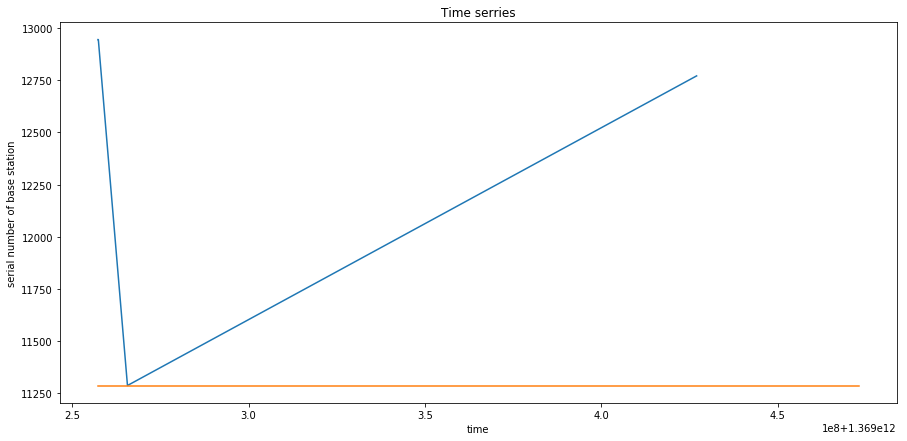

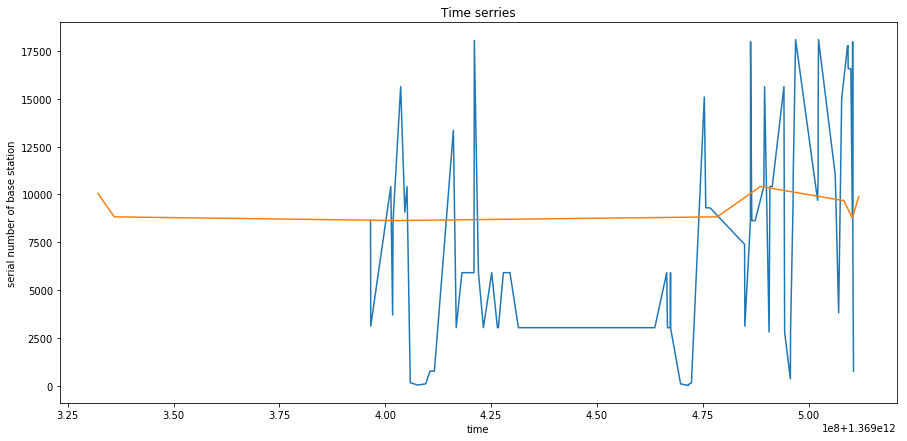

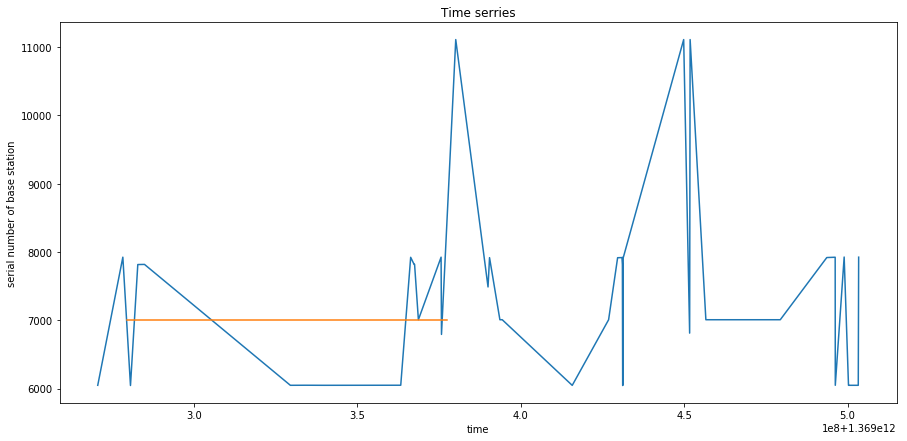

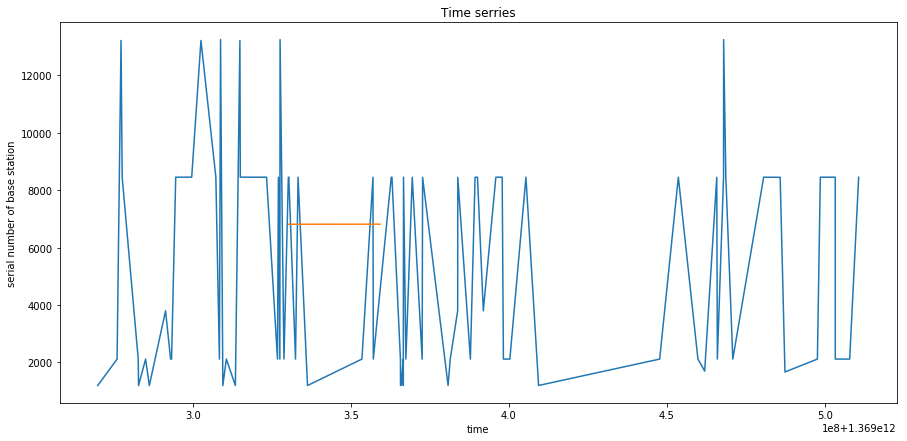

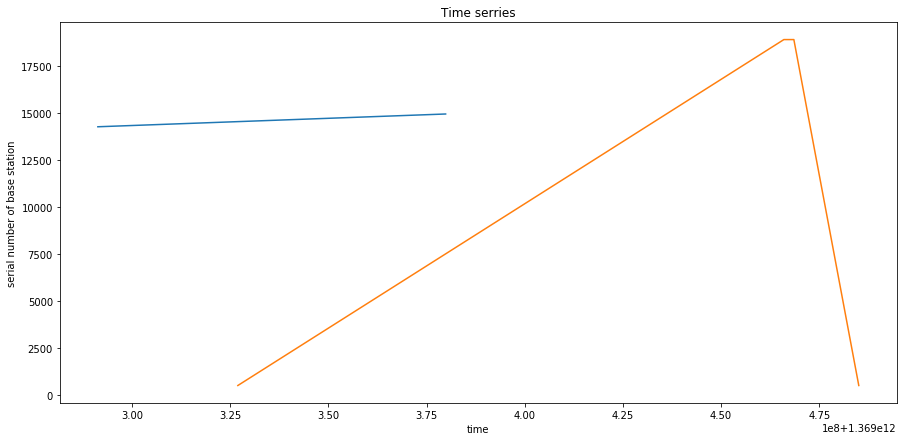

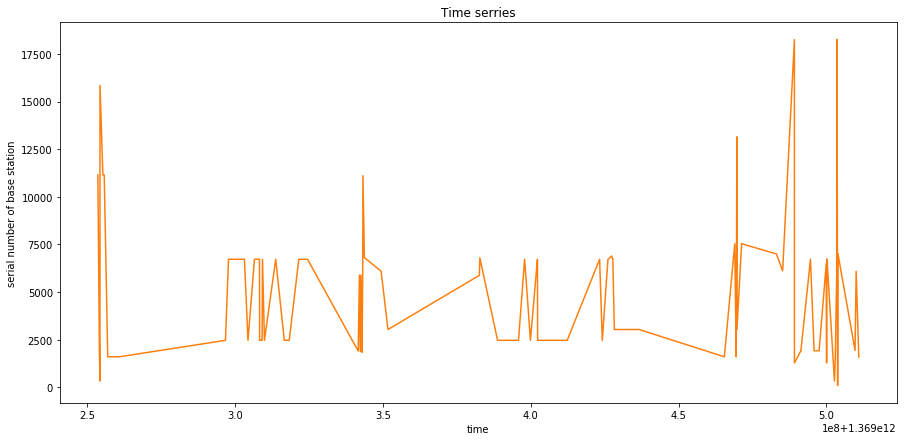

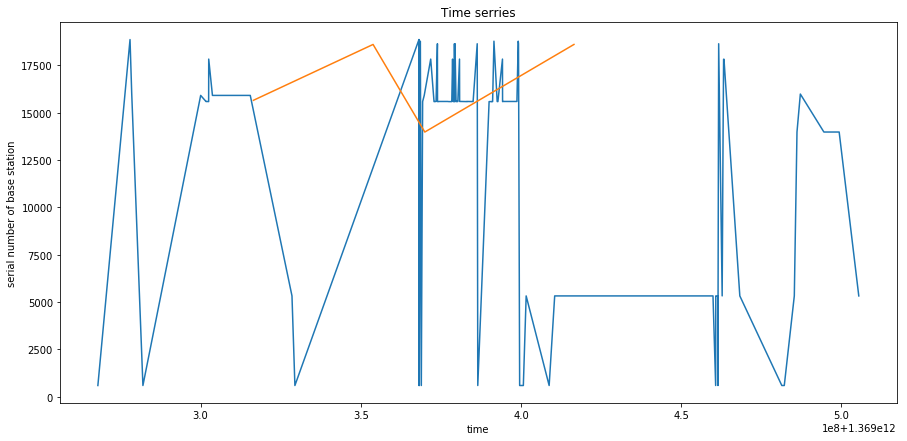

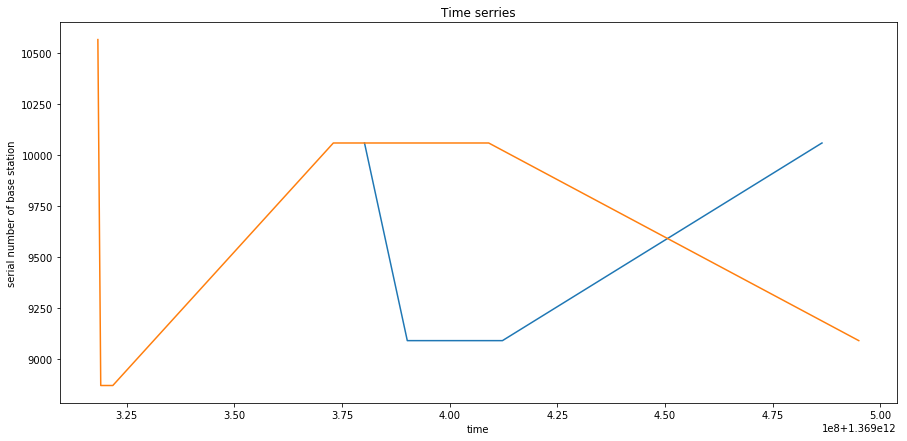

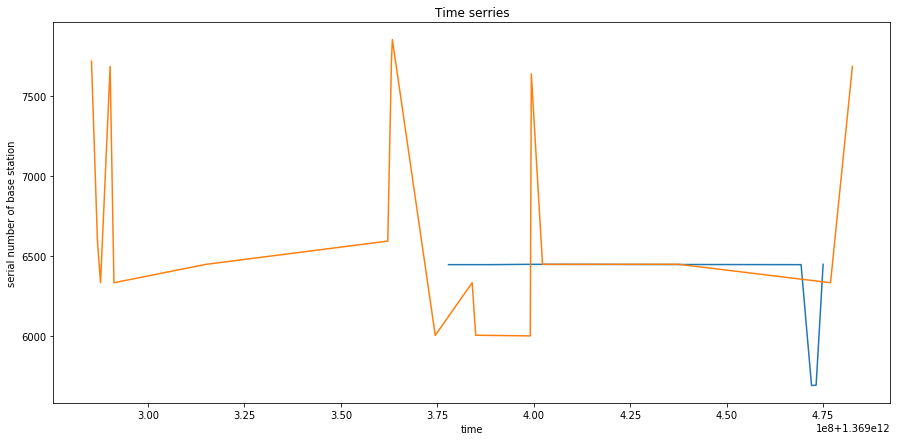

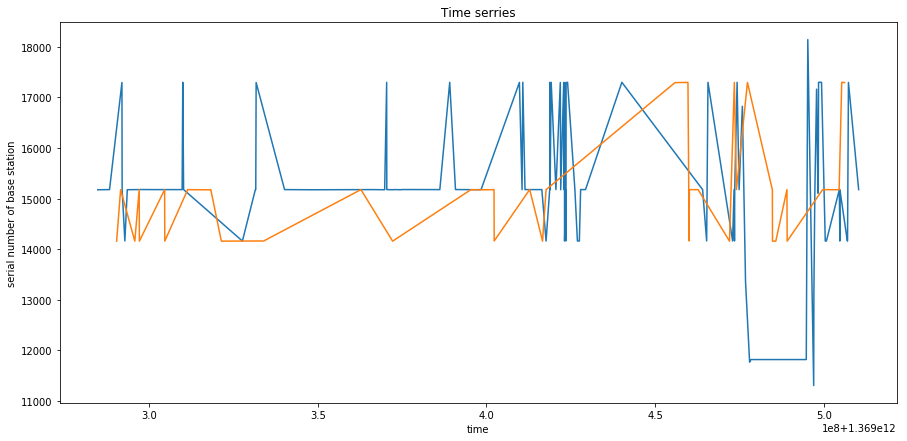

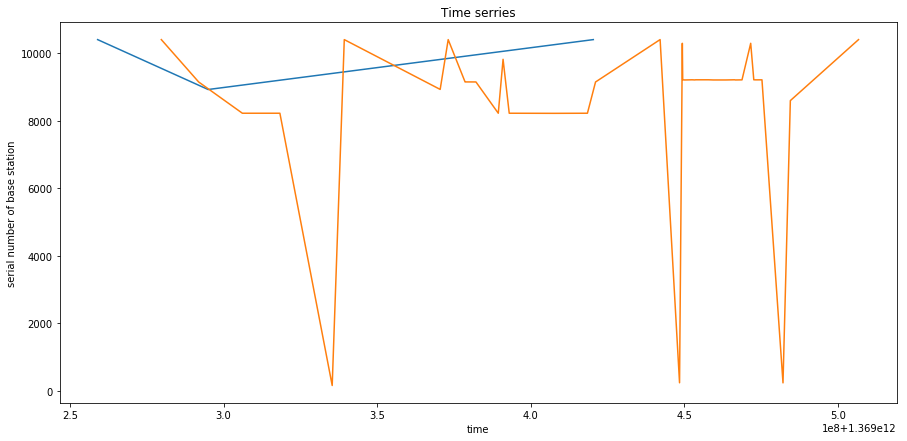

In [562]:
for i in range(120):
    time_series_plotter(np.array(facts).T[0][i],np.array(facts).T[1][i])

### 4. Идея с классификацией

#### Запишем в отдельный массив все уникальные номера

In [3]:
msisdn = np.unique(data_test.msisdn)
len(msisdn)

2361

#### Теперь вычислим сколько номеров проходило через каждую станцию

In [27]:
groupby_station = data_test.groupby(['cid', 'msisdn']).size().reset_index(name='counts')
stations,counts = np.unique(groupby_station.cid, return_counts=True)
print('Меньше или равно 4: ',len(np.where(counts<=4)[0]),'\n','Более 4: ',len(np.where(counts>4)[0]))

Меньше или равно 4:  15137 
 Более 4:  3754


####  Из output ячейки сверху видно что через большинство базовых станций проходило не более 4 уникальных номеров,поэтому сосредоточимся на на них, удалив те у которых очень много номеров.

Text(0.5, 1.0, 'Количество уникальных номеров по каждой базовой станции')

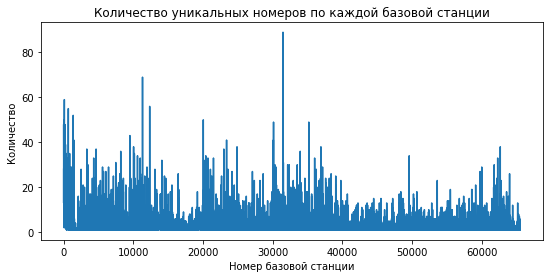

In [76]:
plt.figure(figsize=(9,4))
plt.plot(stations,counts)
plt.xlabel('Номер базовой станции')
plt.ylabel('Количество')
plt.title('Количество уникальных номеров по каждой базовой станции')
#plt.hist(stations)

####  Cоздадим датасет в котором будут такие базовые станции(не более 4 уникальных номеров проходивших в зоне баз.станции)

In [28]:
df = pd.read_csv('02_Data_test.csv', sep = ';')
for i in stations[(np.where(counts>4)[0])]:
    df.drop(df[df.cid == i].index, inplace=True)
for i in stations[(np.where(counts>4)[0])]:
    groupby_station.drop(groupby_station[groupby_station.cid == i].index, inplace=True)
groupby_station.reset_index(drop=True,inplace=True)

#### И также уберем станции которые имели только сигнал от одного номера, что тоже не информативно для определения пар.

In [571]:
for i in stations[(np.where(counts<2)[0])]:
    df.drop(df[df.cid == i].index, inplace=True)
for i in stations[(np.where(counts<2)[0])]:
    groupby_station.drop(groupby_station[groupby_station.cid == i].index, inplace=True)
groupby_station.reset_index(drop=True,inplace=True)

In [573]:
df.shape

(63235, 12)

#### Основываясь на предположении что пара номеров принадлежащих одной персоне(далее Пара) должны как минимум один раз в одном и том же месте иметь чекпоинт, можно сказать что Парой может быть только те номера которые встретились хотя бы раз. "Возможные пары" хороший признак, который нужно будет использовать для модели.

In [29]:
numbers_in_station = []
for i in np.unique(groupby_station.cid):
    numbers_in_station.append((groupby_station.msisdn.loc[np.where(groupby_station.cid==i)[0]]).values)
possible_pairs=[]
for i in numbers_in_station:
    if len(i)>1:
        possible_pairs.append(i)

####  Проверим  имеются ли Пары(из фактов) в "возможных" парах

In [440]:
count=0
for i in facts:
    for j in possible_pairs:
        if i[0] in j and i[1] in j:
            count+=1
            trgt_pssble.append(1)
            break
    else:    
        continue
count/len(facts)

0.5666666666666667

####  Это означает что 56.7% из наших Пар встречались в этих непопулярных зонах, ну и 43.3% встречались где нибудь в другом месте , либо вообще не встречались в течении исследуемого периода. Создадим датафрейм из всевозможных пар уникальных номеров(без фактов).

In [350]:
ms_without_facts = list(msisdn)
for i in np.array(facts).T[0]:
    ms_without_facts.remove(i)
for j in np.array(facts).T[1]:
    ms_without_facts.remove(j)
    
full_data = list(itertools.combinations(ms_without_facts,2))
full_data = pd.DataFrame(full_data, columns=['t1','t2'])
full_data.shape

(2248260, 2)

#### Так же можно определить номера с общим imei  что точно говорит о том что они принадлежат одной персоне, таким образом мы получили 5 новых пар

In [536]:
groupby_imei = data_test.groupby(['imei', 'msisdn']).size().reset_index(name='counts')
new_facts = []
for i in np.unique(groupby_imei.imei):
    if len(groupby_imei.msisdn.values[np.where(groupby_imei.imei==i)[0]])>1:
        new_facts.append(groupby_imei.msisdn.values[np.where(groupby_imei.imei==i)[0]])

In [546]:
idx=0
for i in np.array(new_facts).T[1]:
    if i in np.array(facts).T[0]:
        new_facts.pop(idx)
        print(i)
    elif i in np.array(facts).T[1]:
        new_facts.pop(idx)
        print(i)
    idx+=1

In [547]:
print(len(new_facts))

5


####  Теперь создадим train data, test data. Для начала возьмем рандомные пары(600 штук) из full_data, и присвоем им "0"( предположим что они не принадлежат одной персоне), а фактам "1"(колонка "target"). Всем парам которые имеются в листе возможных пар присвоим  "1", остальным "0" в колонке "possible_pair".

In [554]:
random.seed(123123213)
facts = np.vstack((facts,new_facts))
fake = random.sample(list(full_data.values),600)
batch = pd.DataFrame(np.vstack((facts,fake)),columns=['t1','t2'])
trgt = np.hstack((np.ones(125),np.zeros(600)))
batch['target'] = trgt

In [556]:
trgt_pssble = []
for i in np.vstack((facts,fake)):
    for j in possible_pairs:
        if (i[0] in j) and (i[1] in j):
            trgt_pssble.append(1)
            break
    else:
        trgt_pssble.append(0)
        continue
batch['possible_pair'] = trgt_pssble

### Дополним признаки

#### Приведем колонку с временем в более привычный вид

In [152]:
data_test['tstamp']=data_test['tstamp'].astype('datetime64[ms]')

#### Для каждой пары из batch , определим новые данные с помощью функции выше(speed_dist_calculator). То каким образом это высчитывается, описано комментариями внутри функции

In [794]:
batch_t_array=[]
for i,j in zip(batch.t1.values,batch.t2.values):
    batch_t_array.append([i,j])
#************************************************
new_data=[]
for i in batch_t_array:
    new_data.append(speed_dist_calculator(i))

In [799]:
final_batch = pd.concat([batch, pd.DataFrame(new_data)], axis=1, sort=False)

In [834]:
final_batch.head()

t1            t2  target  possible_pair        dist        ratio  \
0  158530067653  158528861653     1.0              1  534.532790  1212.328850   
1  158530063945  158528861599     1.0              1  316.441614     7.663969   
2  158524011325  158524011355     1.0              1  410.427996    26.050420   
3  158528852153  158528861475     1.0              1  385.250199   195.253985   
4  158510912383  158524011019     1.0              1  178.796793   344.567493   

          speed   speedT2T1  
0   1437.137723    1.185436  
1    470.643573   61.409897  
2    506.438957   19.440721  
3  23324.858093  119.459063  
4   3752.025740   10.889088

In [861]:
final_batch.to_csv('final_batch.csv')

#### Random forest

#### Разделим наши данные на train и test  в отношении 70 на 30

In [75]:
X_train,X_test,y_train,y_test = train_test_split(final_batch[['possible_pair',
                                                              'dist','ratio','speed',
                                                              'speedT2T1']].values,
                                                 final_batch.target.values,test_size=0.3, shuffle=True)

In [93]:
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1)

In [77]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [78]:
pred = rf.predict(X_test)

#### Получили следующий score

In [79]:
roc_auc_score(pred,y_test)

0.9029304029304029

In [80]:
confusion_matrix(pred,y_test)

array([[177,   5],
       [  6,  30]])

#### Теперь используем эту модель для  предсказывания персон. Сперва обучимся на всем final_batch.

In [104]:
X,y = final_batch[['possible_pair', 'dist','ratio','speed','speedT2T1']].values,final_batch.target.values

In [105]:
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

## Сформируем наконец список Персон

#### В идеале нужно пробежаться по всем комбинация пар из full_data и для каждого получить вероятность принадлежности к классу 1. Затем отранжировав по этим значениям, взять максимальные и включить в список Персон. Но так как у меня слабый компьютер, и соотвественно такая схема невозможна, я решил использовать упрощенный вариант: включать в список Персон - каждую пару получившию класс 1 и дальше не рассматривать комбинации с этими номерами.

In [ ]:
#Цикл для предсказывания персон
person=[]
shuffle_person=[]
for i in tqdm(full_data_list): #бежим по всем парам
    if (i[0] not in shuffle_person) and (i[1] not in shuffle_person): #чекаем бан-лист
    #********************************************************
        mikro_batch = speed_dist_calculator(i) #вычисляем наши признаки
        predict = rf.predict(mikro_batch.reshape(1, -1)) #reshape если для данные состоят из одного сэмпла
    #********************************************************
        if predict==1:
            person.append(np.array(i)) #заполняем наш лист с Персонами
            shuffle_person.append(i[0]) #заполняем наш бан-лист
            shuffle_person.append(i[1])
    #*********************************************************

#### Цикл выше исполнялся в течении нескольки часов, и был исполнен только на 87% ввиду проблем описанных выше. Перезапускать до 100% я не стал.

In [206]:
person

[array([158500002513, 158501710783]),
 array([158500006927, 158502685299]),
 array([158500010757, 158502576385]),
 array([158500013119, 158500451183]),
 array([158500019021, 158500407957]),
 array([158500020139, 158500040977]),
 array([158500039411, 158501442891]),
 array([158500040851, 158502267271]),
 array([158500052757, 158500515655]),
 array([158500118785, 158500273073]),
 array([158500129117, 158500594507]),
 array([158500159523, 158506113951]),
 array([158500200323, 158500569307]),
 array([158500214435, 158502269467]),
 array([158500229107, 158500812279]),
 array([158500237627, 158506045029]),
 array([158500408895, 158500784453]),
 array([158500422461, 158503313483]),
 array([158500428729, 158503939843]),
 array([158500436801, 158500478923]),
 array([158500447553, 158500597129]),
 array([158500454525, 158501628681]),
 array([158500457901, 158501702411]),
 array([158500468857, 158500950797]),
 array([158500479921, 158501366425]),
 array([158500484429, 158501310415]),
 array([1585

In [205]:
np.savetxt('Person.txt',person,fmt='%f')

# Заключение

####  По решению этой задачи были опробованы несколько идей:с замерами расстояний между векторами объектами(номерами)(которые были сгенерированы после подсчета количества чекпоинтов на каждой базовой станции, с последующим понижением размерности векторов методом главных компонент),с временными рядами перемещений номеров в течении иследуемого периода и с классификацией. 
####  Первые две идеи были отвергнуты ввиду несостоятельности результатов на выборке фактов.
#### На основе полученного факта,что большинство базовых станций имеют малое количество уникальных номеров(от которых был получен сигнал) и предположения что номера одной Персоны должны встретиться хотя бы раз на одной из базовых станций были придуманы новые признаки. После анализа колонки с imei, массив Фактов был расширен номерами имеющих одинаковые девайсы.Так же для каждой пары были рассчитаны  расстояния и скорости по известным координатам и времени, после чего получена модель с помощью которой были предсказаны Персоны(с некоторыми техническими нюансами описанными выше).
####  Благодарю за задачу, надеюсь в любом случае вы поделитесь ее правильным решением.
